In [39]:
# Import libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from math import sqrt
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectFromModel

# Suppress all warnings
import warnings
warnings.simplefilter("ignore")

plt.style.use('fivethirtyeight')

## Initial `XGBoost`

In [10]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct' 

In [11]:
df.columns

Index(['Date', 'MMWR_week', 'Location', 'Distributed', 'Distributed_Janssen',
       'Distributed_Moderna', 'Distributed_Pfizer', 'Distributed_Unk_Manuf',
       'Dist_Per_100K', 'Distributed_Per_100k_5Plus',
       'Distributed_Per_100k_12Plus', 'Distributed_Per_100k_18Plus',
       'Distributed_Per_100k_65Plus', 'Administered', 'Administered_5Plus',
       'Administered_12Plus', 'Administered_18Plus', 'Administered_65Plus',
       'Administered_Janssen', 'Administered_Moderna', 'Administered_Pfizer',
       'Administered_Unk_Manuf', 'Admin_Per_100K', 'Admin_Per_100k_5Plus',
       'Admin_Per_100k_12Plus', 'Admin_Per_100k_18Plus',
       'Admin_Per_100k_65Plus', 'Recip_Administered',
       'Administered_Dose1_Pop_Pct', 'Administered_Dose1_Recip_5PlusPop_Pct',
       'Administered_Dose1_Recip_12PlusPop_Pct',
       'Administered_Dose1_Recip_18PlusPop_Pct',
       'Administered_Dose1_Recip_65PlusPop_Pct', 'Series_Complete_Pop_Pct',
       'Series_Complete_5PlusPop_Pct', 'Series_Complet

In [7]:
# Tune with for-loop
df['rolling_mean'] = df[pred_var].shift().rolling(window=3).mean()
df['rolling_std'] = df[pred_var].shift().rolling(window=3).std()

In [8]:
# splitting the data (try 70,15,15)
train_size = int(len(df) * 0.8)

# Create two x_test and x_test2
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [12]:
# Set up XGBoost data structures
X_train, y_train = train.drop(pred_var, axis=1), train[pred_var]
X_test, y_test = test.drop(pred_var, axis=1), test[pred_var]

# Convert categorical columns to one-hot encoded columns
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Ensure columns in X_train and X_test are the same after one-hot encoding
missing_cols = set(X_train.columns) - set(X_test.columns)
    # Create a new DataFrame missing_data with the same index as X_test, columns as missing_cols, and fill it with 
    # zeros.
missing_data = pd.DataFrame(0, index=X_test.index, columns=list(missing_cols))
    # Concatenate X_test and missing_data side by side (using axis=1) and then reorder the columns to match 
    # X_train.
X_test = pd.concat([X_test, missing_data], axis=1)[X_train.columns]

data_train = xgb.DMatrix(X_train, label=y_train)
data_test = xgb.DMatrix(X_test, label=y_test)


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [17]:
# Parameters for the model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'learning_rate': 0.01
}

# Training the model with the specified number of boosting rounds
# Put one test group in evals and one just after model is trained
model = xgb.train(params, data_train, num_boost_round=1000, evals=[(data_train, 'train'), (data_test, 'test')])


[0]	train-rmse:47.79882	test-rmse:30.43308
[1]	train-rmse:47.32259	test-rmse:30.12923
[2]	train-rmse:46.85111	test-rmse:29.82266
[3]	train-rmse:46.38437	test-rmse:29.52281
[4]	train-rmse:45.92225	test-rmse:29.22581
[5]	train-rmse:45.46477	test-rmse:28.93159
[6]	train-rmse:45.01186	test-rmse:28.64017
[7]	train-rmse:44.56349	test-rmse:28.35367
[8]	train-rmse:44.11959	test-rmse:28.06803
[9]	train-rmse:43.68013	test-rmse:27.78554
[10]	train-rmse:43.24505	test-rmse:27.50787
[11]	train-rmse:42.81433	test-rmse:27.23454
[12]	train-rmse:42.38789	test-rmse:26.96070
[13]	train-rmse:41.96573	test-rmse:26.69288
[14]	train-rmse:41.54778	test-rmse:26.42637
[15]	train-rmse:41.13400	test-rmse:26.16076
[16]	train-rmse:40.72435	test-rmse:25.90125
[17]	train-rmse:40.31880	test-rmse:25.64059
[18]	train-rmse:39.91730	test-rmse:25.38654
[19]	train-rmse:39.51982	test-rmse:25.12804
[20]	train-rmse:39.12629	test-rmse:24.87904
[21]	train-rmse:38.73671	test-rmse:24.63009
[22]	train-rmse:38.35099	test-rmse:24.3847

[187]	train-rmse:7.37835	test-rmse:4.34481
[188]	train-rmse:7.30526	test-rmse:4.30119
[189]	train-rmse:7.23289	test-rmse:4.25840
[190]	train-rmse:7.16124	test-rmse:4.21494
[191]	train-rmse:7.09031	test-rmse:4.17246
[192]	train-rmse:7.02010	test-rmse:4.13026
[193]	train-rmse:6.95057	test-rmse:4.08924
[194]	train-rmse:6.88175	test-rmse:4.04810
[195]	train-rmse:6.81361	test-rmse:4.00820
[196]	train-rmse:6.74613	test-rmse:3.96899
[197]	train-rmse:6.67933	test-rmse:3.92961
[198]	train-rmse:6.61320	test-rmse:3.89160
[199]	train-rmse:6.54772	test-rmse:3.85342
[200]	train-rmse:6.48293	test-rmse:3.81795
[201]	train-rmse:6.41876	test-rmse:3.78110
[202]	train-rmse:6.35522	test-rmse:3.74398
[203]	train-rmse:6.29233	test-rmse:3.70738
[204]	train-rmse:6.23005	test-rmse:3.67043
[205]	train-rmse:6.16841	test-rmse:3.63348
[206]	train-rmse:6.10736	test-rmse:3.59804
[207]	train-rmse:6.04695	test-rmse:3.56419
[208]	train-rmse:5.98712	test-rmse:3.52933
[209]	train-rmse:5.92788	test-rmse:3.49484
[210]	train

[378]	train-rmse:1.13267	test-rmse:1.75580
[379]	train-rmse:1.12198	test-rmse:1.75654
[380]	train-rmse:1.11140	test-rmse:1.75710
[381]	train-rmse:1.10091	test-rmse:1.75791
[382]	train-rmse:1.09053	test-rmse:1.75867
[383]	train-rmse:1.08030	test-rmse:1.75860
[384]	train-rmse:1.07015	test-rmse:1.75954
[385]	train-rmse:1.06010	test-rmse:1.76052
[386]	train-rmse:1.05018	test-rmse:1.76051
[387]	train-rmse:1.04032	test-rmse:1.76150
[388]	train-rmse:1.03058	test-rmse:1.76156
[389]	train-rmse:1.02094	test-rmse:1.76232
[390]	train-rmse:1.01141	test-rmse:1.76312
[391]	train-rmse:1.00195	test-rmse:1.76317
[392]	train-rmse:0.99259	test-rmse:1.76368
[393]	train-rmse:0.98333	test-rmse:1.76389
[394]	train-rmse:0.97418	test-rmse:1.76406
[395]	train-rmse:0.96512	test-rmse:1.76415
[396]	train-rmse:0.95614	test-rmse:1.76508
[397]	train-rmse:0.94724	test-rmse:1.76521
[398]	train-rmse:0.93846	test-rmse:1.76550
[399]	train-rmse:0.92975	test-rmse:1.76586
[400]	train-rmse:0.92114	test-rmse:1.76611
[401]	train

[569]	train-rmse:0.24976	test-rmse:1.85883
[570]	train-rmse:0.24847	test-rmse:1.85893
[571]	train-rmse:0.24721	test-rmse:1.85932
[572]	train-rmse:0.24598	test-rmse:1.86010
[573]	train-rmse:0.24470	test-rmse:1.86026
[574]	train-rmse:0.24345	test-rmse:1.86035
[575]	train-rmse:0.24221	test-rmse:1.86067
[576]	train-rmse:0.24094	test-rmse:1.86098
[577]	train-rmse:0.23974	test-rmse:1.86113
[578]	train-rmse:0.23854	test-rmse:1.86146
[579]	train-rmse:0.23741	test-rmse:1.86222
[580]	train-rmse:0.23629	test-rmse:1.86260
[581]	train-rmse:0.23515	test-rmse:1.86271
[582]	train-rmse:0.23396	test-rmse:1.86300
[583]	train-rmse:0.23285	test-rmse:1.86308
[584]	train-rmse:0.23168	test-rmse:1.86336
[585]	train-rmse:0.23056	test-rmse:1.86383
[586]	train-rmse:0.22951	test-rmse:1.86416
[587]	train-rmse:0.22841	test-rmse:1.86443
[588]	train-rmse:0.22737	test-rmse:1.86455
[589]	train-rmse:0.22630	test-rmse:1.86481
[590]	train-rmse:0.22532	test-rmse:1.86549
[591]	train-rmse:0.22432	test-rmse:1.86560
[592]	train

[760]	train-rmse:0.15332	test-rmse:1.88412
[761]	train-rmse:0.15321	test-rmse:1.88416
[762]	train-rmse:0.15303	test-rmse:1.88421
[763]	train-rmse:0.15289	test-rmse:1.88431
[764]	train-rmse:0.15275	test-rmse:1.88433
[765]	train-rmse:0.15262	test-rmse:1.88438
[766]	train-rmse:0.15248	test-rmse:1.88452
[767]	train-rmse:0.15235	test-rmse:1.88453
[768]	train-rmse:0.15215	test-rmse:1.88453
[769]	train-rmse:0.15204	test-rmse:1.88456
[770]	train-rmse:0.15187	test-rmse:1.88467
[771]	train-rmse:0.15174	test-rmse:1.88460
[772]	train-rmse:0.15162	test-rmse:1.88464
[773]	train-rmse:0.15150	test-rmse:1.88461
[774]	train-rmse:0.15138	test-rmse:1.88465
[775]	train-rmse:0.15126	test-rmse:1.88473
[776]	train-rmse:0.15116	test-rmse:1.88468
[777]	train-rmse:0.15100	test-rmse:1.88478
[778]	train-rmse:0.15088	test-rmse:1.88483
[779]	train-rmse:0.15069	test-rmse:1.88482
[780]	train-rmse:0.15055	test-rmse:1.88486
[781]	train-rmse:0.15045	test-rmse:1.88492
[782]	train-rmse:0.15036	test-rmse:1.88496
[783]	train

[951]	train-rmse:0.13612	test-rmse:1.88955
[952]	train-rmse:0.13606	test-rmse:1.88968
[953]	train-rmse:0.13600	test-rmse:1.88967
[954]	train-rmse:0.13593	test-rmse:1.88957
[955]	train-rmse:0.13587	test-rmse:1.88957
[956]	train-rmse:0.13580	test-rmse:1.88962
[957]	train-rmse:0.13573	test-rmse:1.88964
[958]	train-rmse:0.13568	test-rmse:1.88949
[959]	train-rmse:0.13564	test-rmse:1.88952
[960]	train-rmse:0.13556	test-rmse:1.88963
[961]	train-rmse:0.13549	test-rmse:1.88960
[962]	train-rmse:0.13538	test-rmse:1.88969
[963]	train-rmse:0.13531	test-rmse:1.88968
[964]	train-rmse:0.13526	test-rmse:1.88968
[965]	train-rmse:0.13518	test-rmse:1.88965
[966]	train-rmse:0.13512	test-rmse:1.88967
[967]	train-rmse:0.13506	test-rmse:1.88971
[968]	train-rmse:0.13499	test-rmse:1.88969
[969]	train-rmse:0.13493	test-rmse:1.88973
[970]	train-rmse:0.13484	test-rmse:1.88981
[971]	train-rmse:0.13478	test-rmse:1.88977
[972]	train-rmse:0.13471	test-rmse:1.88915
[973]	train-rmse:0.13464	test-rmse:1.88928
[974]	train

In [19]:
# Forecasting and Evaluation

y_pred = model.predict(data_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Compute RMSE
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error: 3.563267669060175
Root Mean Squared Error (RMSE): 1.8876619583654737


## Round 2 `XGBoost`

In [ ]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Sorting data by date and state
df = df.sort_values(by=['Date', 'Location'])

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct' 
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# Tune with for-loop
df['rolling_mean'] = df[pred_var].shift().rolling(window=3).mean()
df['rolling_std'] = df[pred_var].shift().rolling(window=3).std()

In [ ]:
# One-hot encoding of the entire dataframe
df_encoded = pd.get_dummies(df)

# Split the dataset based on unique dates
splits_by_date = [df_encoded[df_encoded['Date'] == date] for date in df_encoded['Date'].unique()]

# TimeSeriesSplit for CV
# I made the test_size = 4 because I think a month's worth of data is sufficient

tscv = TimeSeriesSplit(n_splits=5, test_size = 4, gap = 3)

for train_index, test_index in tscv.split(splits_by_date):
    train = pd.concat([splits_by_date[i] for i in train_index])
    test = pd.concat([splits_by_date[i] for i in test_index])


In [21]:
# Set up XGBoost data structures
X_train, y_train = train.drop([pred_var, 'Date'], axis=1), train[pred_var]
X_test, y_test = test.drop([pred_var, 'Date'], axis=1), test[pred_var]

In [22]:
reg = xgb.XGBRegressor(learning_rate=0.01,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
       verbose=True)

[14:06:54] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:43.67712	validation_1-rmse:50.56846
[1]	validation_0-rmse:43.24219	validation_1-rmse:50.07177


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-rmse:42.81159	validation_1-rmse:49.58011
[3]	validation_0-rmse:42.38531	validation_1-rmse:49.09330
[4]	validation_0-rmse:41.96328	validation_1-rmse:48.61142
[5]	validation_0-rmse:41.54546	validation_1-rmse:48.13432
[6]	validation_0-rmse:41.13183	validation_1-rmse:47.66177
[7]	validation_0-rmse:40.72233	validation_1-rmse:47.19415
[8]	validation_0-rmse:40.31688	validation_1-rmse:46.73100
[9]	validation_0-rmse:39.91551	validation_1-rmse:46.27267
[10]	validation_0-rmse:39.51815	validation_1-rmse:45.81889
[11]	validation_0-rmse:39.12471	validation_1-rmse:45.37043
[12]	validation_0-rmse:38.73521	validation_1-rmse:44.92441
[13]	validation_0-rmse:38.34959	validation_1-rmse:44.48375
[14]	validation_0-rmse:37.96782	validation_1-rmse:44.04798
[15]	validation_0-rmse:37.58986	validation_1-rmse:43.61492
[16]	validation_0-rmse:37.21567	validation_1-rmse:43.18688
[17]	validation_0-rmse:36.84521	validation_1-rmse:42.76435
[18]	validation_0-rmse:36.47845	validation_1-rmse:42.34523
[19]	

[141]	validation_0-rmse:10.67866	validation_1-rmse:12.89287
[142]	validation_0-rmse:10.57277	validation_1-rmse:12.76967
[143]	validation_0-rmse:10.46790	validation_1-rmse:12.65006
[144]	validation_0-rmse:10.36410	validation_1-rmse:12.53046
[145]	validation_0-rmse:10.26130	validation_1-rmse:12.41373
[146]	validation_0-rmse:10.15953	validation_1-rmse:12.29719
[147]	validation_0-rmse:10.05879	validation_1-rmse:12.18175
[148]	validation_0-rmse:9.95904	validation_1-rmse:12.06751
[149]	validation_0-rmse:9.86034	validation_1-rmse:11.95305
[150]	validation_0-rmse:9.76257	validation_1-rmse:11.84199
[151]	validation_0-rmse:9.66578	validation_1-rmse:11.73119
[152]	validation_0-rmse:9.56995	validation_1-rmse:11.62230
[153]	validation_0-rmse:9.47510	validation_1-rmse:11.51382
[154]	validation_0-rmse:9.38118	validation_1-rmse:11.40615
[155]	validation_0-rmse:9.28824	validation_1-rmse:11.29811
[156]	validation_0-rmse:9.19621	validation_1-rmse:11.19033
[157]	validation_0-rmse:9.10508	validation_1-rmse

[282]	validation_0-rmse:2.64143	validation_1-rmse:3.51451
[283]	validation_0-rmse:2.61563	validation_1-rmse:3.48433
[284]	validation_0-rmse:2.59012	validation_1-rmse:3.45353
[285]	validation_0-rmse:2.56483	validation_1-rmse:3.42270
[286]	validation_0-rmse:2.53980	validation_1-rmse:3.39355
[287]	validation_0-rmse:2.51502	validation_1-rmse:3.36391
[288]	validation_0-rmse:2.49052	validation_1-rmse:3.33438
[289]	validation_0-rmse:2.46624	validation_1-rmse:3.30451
[290]	validation_0-rmse:2.44218	validation_1-rmse:3.27744
[291]	validation_0-rmse:2.41840	validation_1-rmse:3.24887
[292]	validation_0-rmse:2.39484	validation_1-rmse:3.21998
[293]	validation_0-rmse:2.37150	validation_1-rmse:3.19166
[294]	validation_0-rmse:2.34840	validation_1-rmse:3.16428
[295]	validation_0-rmse:2.32555	validation_1-rmse:3.13668
[296]	validation_0-rmse:2.30290	validation_1-rmse:3.10844
[297]	validation_0-rmse:2.28048	validation_1-rmse:3.08170
[298]	validation_0-rmse:2.25832	validation_1-rmse:3.05489
[299]	validati

[424]	validation_0-rmse:0.68417	validation_1-rmse:1.13468
[425]	validation_0-rmse:0.67808	validation_1-rmse:1.12719
[426]	validation_0-rmse:0.67200	validation_1-rmse:1.11943
[427]	validation_0-rmse:0.66606	validation_1-rmse:1.11187
[428]	validation_0-rmse:0.66017	validation_1-rmse:1.10403
[429]	validation_0-rmse:0.65433	validation_1-rmse:1.09636
[430]	validation_0-rmse:0.64855	validation_1-rmse:1.08876
[431]	validation_0-rmse:0.64280	validation_1-rmse:1.08149
[432]	validation_0-rmse:0.63714	validation_1-rmse:1.07394
[433]	validation_0-rmse:0.63153	validation_1-rmse:1.06695
[434]	validation_0-rmse:0.62603	validation_1-rmse:1.05947
[435]	validation_0-rmse:0.62059	validation_1-rmse:1.05326
[436]	validation_0-rmse:0.61513	validation_1-rmse:1.04635
[437]	validation_0-rmse:0.60977	validation_1-rmse:1.04025
[438]	validation_0-rmse:0.60450	validation_1-rmse:1.03331
[439]	validation_0-rmse:0.59926	validation_1-rmse:1.02690
[440]	validation_0-rmse:0.59403	validation_1-rmse:1.02025
[441]	validati

[566]	validation_0-rmse:0.23753	validation_1-rmse:0.56882
[567]	validation_0-rmse:0.23624	validation_1-rmse:0.56715
[568]	validation_0-rmse:0.23492	validation_1-rmse:0.56527
[569]	validation_0-rmse:0.23362	validation_1-rmse:0.56335
[570]	validation_0-rmse:0.23234	validation_1-rmse:0.56156
[571]	validation_0-rmse:0.23111	validation_1-rmse:0.55959
[572]	validation_0-rmse:0.22986	validation_1-rmse:0.55783
[573]	validation_0-rmse:0.22864	validation_1-rmse:0.55624
[574]	validation_0-rmse:0.22751	validation_1-rmse:0.55450
[575]	validation_0-rmse:0.22631	validation_1-rmse:0.55282
[576]	validation_0-rmse:0.22513	validation_1-rmse:0.55118
[577]	validation_0-rmse:0.22401	validation_1-rmse:0.54990
[578]	validation_0-rmse:0.22287	validation_1-rmse:0.54838
[579]	validation_0-rmse:0.22180	validation_1-rmse:0.54662
[580]	validation_0-rmse:0.22072	validation_1-rmse:0.54492
[581]	validation_0-rmse:0.21968	validation_1-rmse:0.54319
[582]	validation_0-rmse:0.21863	validation_1-rmse:0.54189
[583]	validati

[708]	validation_0-rmse:0.15073	validation_1-rmse:0.42058
[709]	validation_0-rmse:0.15052	validation_1-rmse:0.42021
[710]	validation_0-rmse:0.15027	validation_1-rmse:0.41952
[711]	validation_0-rmse:0.15002	validation_1-rmse:0.41884
[712]	validation_0-rmse:0.14979	validation_1-rmse:0.41848
[713]	validation_0-rmse:0.14955	validation_1-rmse:0.41782
[714]	validation_0-rmse:0.14934	validation_1-rmse:0.41738
[715]	validation_0-rmse:0.14913	validation_1-rmse:0.41678
[716]	validation_0-rmse:0.14893	validation_1-rmse:0.41643
[717]	validation_0-rmse:0.14872	validation_1-rmse:0.41576
[718]	validation_0-rmse:0.14852	validation_1-rmse:0.41534
[719]	validation_0-rmse:0.14828	validation_1-rmse:0.41470
[720]	validation_0-rmse:0.14808	validation_1-rmse:0.41436
[721]	validation_0-rmse:0.14789	validation_1-rmse:0.41370
[722]	validation_0-rmse:0.14766	validation_1-rmse:0.41319
[723]	validation_0-rmse:0.14747	validation_1-rmse:0.41286
[724]	validation_0-rmse:0.14724	validation_1-rmse:0.41222
[725]	validati

[850]	validation_0-rmse:0.13024	validation_1-rmse:0.37804
[851]	validation_0-rmse:0.13013	validation_1-rmse:0.37790
[852]	validation_0-rmse:0.13005	validation_1-rmse:0.37780
[853]	validation_0-rmse:0.12999	validation_1-rmse:0.37771
[854]	validation_0-rmse:0.12988	validation_1-rmse:0.37755
[855]	validation_0-rmse:0.12979	validation_1-rmse:0.37727
[856]	validation_0-rmse:0.12968	validation_1-rmse:0.37714
[857]	validation_0-rmse:0.12960	validation_1-rmse:0.37704
[858]	validation_0-rmse:0.12953	validation_1-rmse:0.37687
[859]	validation_0-rmse:0.12943	validation_1-rmse:0.37673
[860]	validation_0-rmse:0.12937	validation_1-rmse:0.37665
[861]	validation_0-rmse:0.12929	validation_1-rmse:0.37652
[862]	validation_0-rmse:0.12923	validation_1-rmse:0.37652
[863]	validation_0-rmse:0.12913	validation_1-rmse:0.37644
[864]	validation_0-rmse:0.12904	validation_1-rmse:0.37616
[865]	validation_0-rmse:0.12896	validation_1-rmse:0.37606
[866]	validation_0-rmse:0.12887	validation_1-rmse:0.37578
[867]	validati

[992]	validation_0-rmse:0.12022	validation_1-rmse:0.36831
[993]	validation_0-rmse:0.12015	validation_1-rmse:0.36826
[994]	validation_0-rmse:0.12011	validation_1-rmse:0.36823
[995]	validation_0-rmse:0.12004	validation_1-rmse:0.36818
[996]	validation_0-rmse:0.12000	validation_1-rmse:0.36811
[997]	validation_0-rmse:0.11990	validation_1-rmse:0.36811
[998]	validation_0-rmse:0.11982	validation_1-rmse:0.36798
[999]	validation_0-rmse:0.11971	validation_1-rmse:0.36811


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

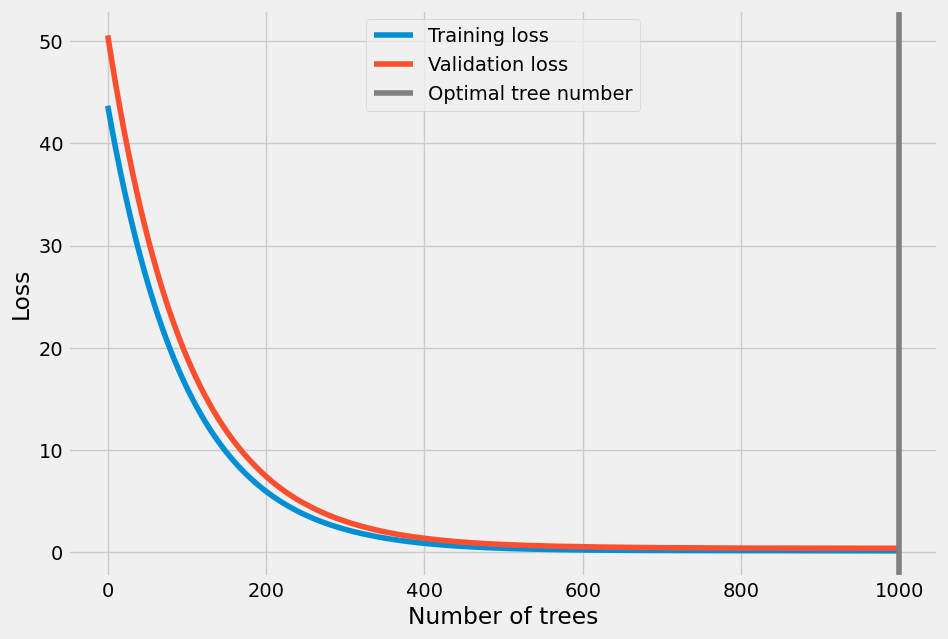

In [23]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [24]:
reg.best_iteration

999

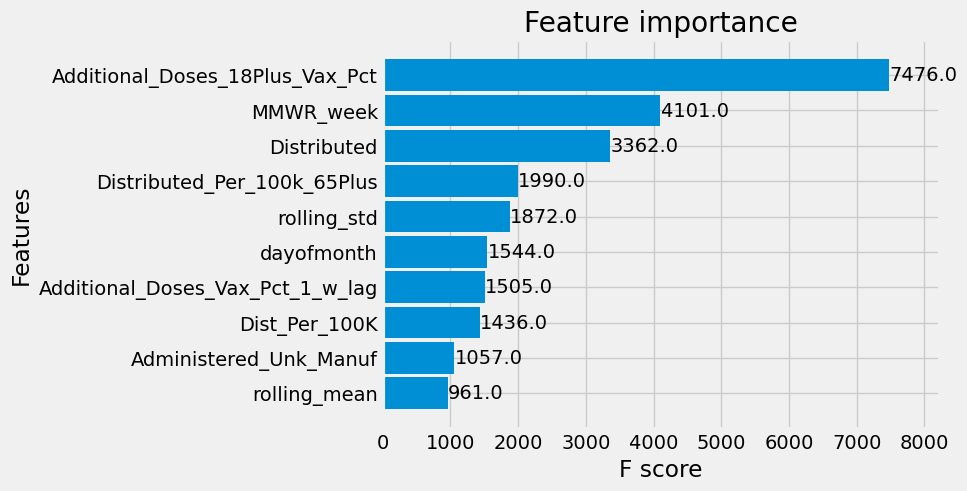

In [31]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

## Round 3 Tuning and adding more lags

In [85]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Sorting data by date and state
df = df.sort_values(by=['Date', 'Location'])

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct' 
df['Date'] = pd.to_datetime(df['Date'])

Decided to remove 6 month lag because of high correlation

In [86]:
# Additional time-series columns to account for 3-month pattern
# 3 month lag
df['Additional_Doses_Vax_Pct_3_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(12)

# # 6 month lag
# df['Additional_Doses_Vax_Pct_6_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(24)

# 9 month lag
df['Additional_Doses_Vax_Pct_9_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(36)

# Rolling statistics
df['rolling_mean'] = df[pred_var].shift().rolling(window=12).mean()
df['rolling_std'] = df[pred_var].shift().rolling(window=12).std()

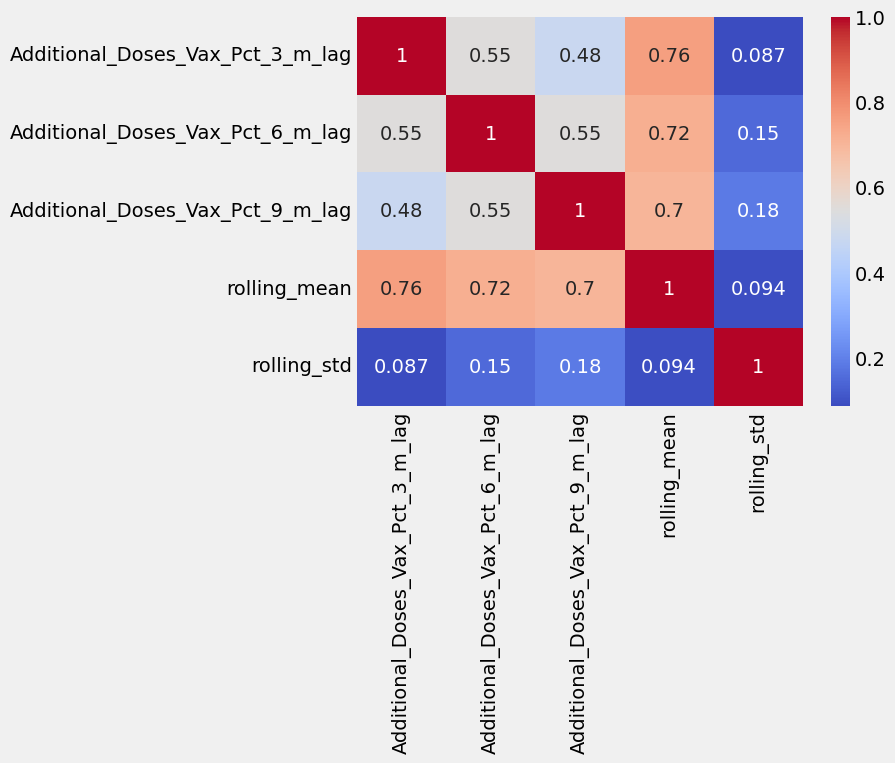

In [28]:
# Correlation matrix
corr_matrix = df[['Additional_Doses_Vax_Pct_3_m_lag', 'Additional_Doses_Vax_Pct_6_m_lag', 'Additional_Doses_Vax_Pct_9_m_lag', 'rolling_mean', 'rolling_std']].corr()

# Visualize the matrix with a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [87]:
# One-hot encoding of the entire dataframe
df_encoded = pd.get_dummies(df)

# Split the dataset based on unique dates
splits_by_date = [df_encoded[df_encoded['Date'] == date] for date in df_encoded['Date'].unique()]

# TimeSeriesSplit
# I made the test_size = 4 because I think a month's worth of data is sufficient

tscv = TimeSeriesSplit(n_splits=5, test_size = 12, gap = 12)

for train_index, test_index in tscv.split(splits_by_date):
    train = pd.concat([splits_by_date[i] for i in train_index])
    test = pd.concat([splits_by_date[i] for i in test_index])


In [88]:
# Set up XGBoost data structures
X_train, y_train = train.drop([pred_var, 'Date'], axis=1), train[pred_var]
X_test, y_test = test.drop([pred_var, 'Date'], axis=1), test[pred_var]

In [6]:
# Define hyperparameter search space
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.3],
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}


In [7]:
# Initialize XGBoost regressor
reg = xgb.XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV and fit
random_search = RandomizedSearchCV(
    reg, param_distributions=param_dist, n_iter=50,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=3, random_state=42
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

KeyboardInterrupt: 

In [9]:
# Print best parameters

print(f"Best parameters found: {random_search.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(random_search.best_score_))}")

Best parameters found: {'subsample': 0.75, 'reg_lambda': 0.31622776601683794, 'reg_alpha': 10.0, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.25, 'colsample_bytree': 1.0}
Lowest RMSE found: 0.8684627487883144


In [10]:
# Evaluate with cross-validation (xgb.cv)
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    random_search.best_params_,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

print(f"Final cross-validated RMSE: {cv_results['test-rmse-mean'].tail(1).values[0]}")


Final cross-validated RMSE: 0.290596


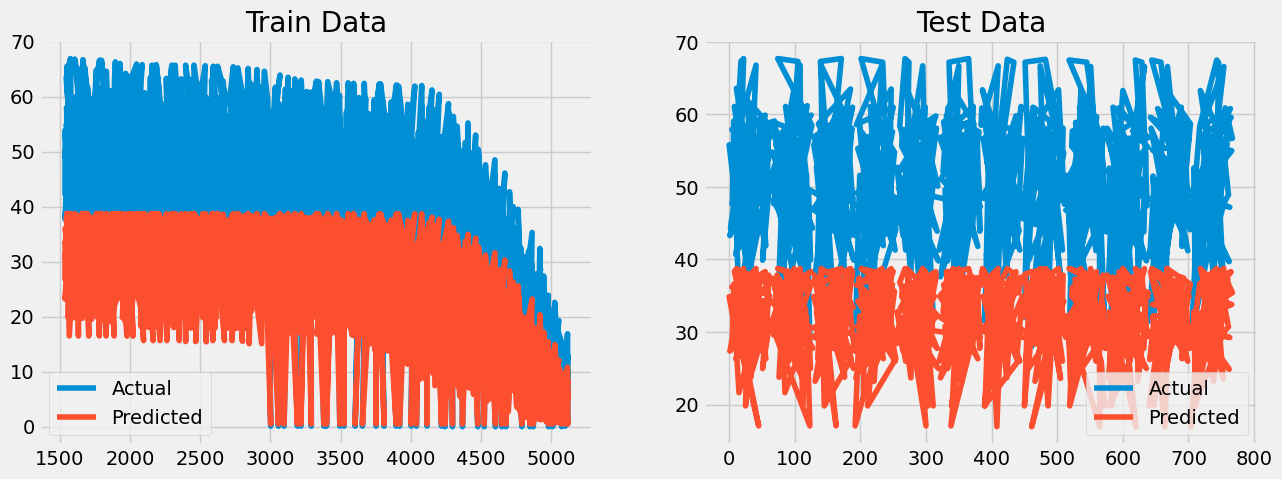

Train RMSE: 15.746561947680021
Test RMSE: 19.40811016530167


In [89]:
# Best parameters
params = {
    'subsample': 0.75,
    'reg_lambda': 0.31622776601683794,
    'reg_alpha': 10.0,
    'min_child_weight': 1,
    'max_depth': 9,
    'learning_rate': 0.01,
    'gamma': 0.25,
    'colsample_bytree': 1.0
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(**params)

# Fit the model
reg.fit(X_train, y_train)

# Make predictions
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Calculate RMSE for train and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_pred))
test_rmse = sqrt(mean_squared_error(y_test, test_pred))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_pred, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_pred, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()

# Show the plots
plt.show()

# Print RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

In [90]:
# Plot test predictions and actual values
pd.concat([y_test, test_pred], axis=1).plot(figsize=(20,10))
plt.legend(['y_test', 'test_pred'])
plt.title('Test Data: Actual vs Predicted')
plt.show()

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

## Second Randomized Search CV

In [6]:
# Best parameters from RandomizedSearchCV
best_params = {
    'subsample': 0.75,
    'reg_lambda': 0.31622776601683794,
    'reg_alpha': 10.0,
    'min_child_weight': 1,
    'max_depth': 9,
    'learning_rate': 0.01,
    'gamma': 0.25,
    'colsample_bytree': 1.0
}

# Define a narrower search space centered around the best parameters
param_dist = {
    'learning_rate': [0.008, 0.01, 0.012],  # 0.8, 1.0 and 1.2 times 0.01
    'max_depth': [8, 9, 10],  # 9 minus 1, 9, 9 plus 1
    'min_child_weight': [1, 2],  # 1 and 1 plus 1
    'gamma': [0.2, 0.25, 0.3],  # 0.8, 1.0 and 1.2 times 0.25
    'subsample': [0.6, 0.75, 0.9],  # 0.8, 1.0 and 1.2 times 0.75
    'colsample_bytree': [0.8, 1.0],  # 0.8 and 1 times 1.0
    'reg_alpha': [5.0, 10.0, 20.0],  # 0.5, 1.0 and 2 times 10.0
    'reg_lambda': [0.158, 0.316, 0.632]  # 0.5, 1.0 and 2 times 0.316
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV and fit
random_search = RandomizedSearchCV(
    reg, param_distributions=param_dist, n_iter=50,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=3, random_state=42
)

random_search.fit(X_train, y_train)

# Print best parameters

print(f"Best parameters found: {random_search.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(random_search.best_score_))}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

In [ ]:
# Evaluate with cross-validation (xgb.cv)
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    random_search.best_params_,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

print(f"Final cross-validated RMSE: {cv_results['test-rmse-mean'].tail(1).values[0]}")


# Grouping by `Date`

In [38]:
# Import data
df = pd.read_csv('df_post_eda.csv')

# Ensure the data is sorted by Date
df.sort_values('Date', inplace=True)

# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct' 
df['Date'] = pd.to_datetime(df['Date'])

# Group by 'Date' to ensure there is one unique value per date
df = df.groupby('Date').mean().reset_index()

# Additional time-series columns to account for 3-month pattern
# 3 month lag
df['Additional_Doses_Vax_Pct_3_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(12)

# 9 month lag
df['Additional_Doses_Vax_Pct_9_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(36)

# Rolling statistics
df['rolling_mean'] = df[pred_var].shift().rolling(window=12).mean()
df['rolling_std'] = df[pred_var].shift().rolling(window=12).std()

# One-hot encoding of the entire dataframe
df_encoded = pd.get_dummies(df)

# Split the dataset based on unique dates
splits_by_date = [df_encoded[df_encoded['Date'] == date] for date in df_encoded['Date'].unique()]

# TimeSeriesSplit
# I made the test_size = 12 because I think a 3 month's worth of data is sufficient

tscv = TimeSeriesSplit(n_splits=3, test_size = 12, gap = 12)

for train_index, test_index in tscv.split(splits_by_date):
    train = pd.concat([splits_by_date[i] for i in train_index])
    test = pd.concat([splits_by_date[i] for i in test_index])
    
# Split into train and test sets
split_index = int(len(df) * 0.7)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

# Set up XGBoost data structures and dropping Date column because it cannot be used directly
X_train, y_train = train.drop([pred_var, 'Date', 'Distributed'], axis=1), train[pred_var]
X_test, y_test = test.drop([pred_var, 'Date', 'Distributed'], axis=1), test[pred_var]

In [33]:
reg = xgb.XGBRegressor(learning_rate=0.01,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[16:43:44] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:41.40430	validation_1-rmse:49.69894
[1]	validation_0-rmse:41.00498	validation_1-rmse:49.27042
[2]	validation_0-rmse:40.60943	validation_1-rmse:48.84351
[3]	validation_0-rmse:40.21793	validation_1-rmse:48.42333
[4]	validation_0-rmse:39.83012	validation_1-rmse:48.00472
[5]	validation_0-rmse:39.44613	validation_1-rmse:47.59021
[6]	validation_0-rmse:39.06606	validation_1-rmse:47.18221
[7]	validation_0-rmse:38.68959	validation_1-rmse:46.77575
[8]	validation_0-rmse:38.31697	validation_1-rmse:46.37569
[9]	validation_0-rmse:37.94765	validation_1-rmse:45.97476
[10]	validation_0-rmse:37.58196	validation_1-rms

[133]	validation_0-rmse:11.53782	validation_1-rmse:16.73661
[134]	validation_0-rmse:11.42855	validation_1-rmse:16.63183
[135]	validation_0-rmse:11.32019	validation_1-rmse:16.50790
[136]	validation_0-rmse:11.21269	validation_1-rmse:16.38309
[137]	validation_0-rmse:11.10643	validation_1-rmse:16.28176
[138]	validation_0-rmse:11.00099	validation_1-rmse:16.15934
[139]	validation_0-rmse:10.89698	validation_1-rmse:16.05908
[140]	validation_0-rmse:10.79353	validation_1-rmse:15.93273
[141]	validation_0-rmse:10.69111	validation_1-rmse:15.81377
[142]	validation_0-rmse:10.59013	validation_1-rmse:15.70100
[143]	validation_0-rmse:10.48963	validation_1-rmse:15.58361
[144]	validation_0-rmse:10.39010	validation_1-rmse:15.46736
[145]	validation_0-rmse:10.29156	validation_1-rmse:15.35225
[146]	validation_0-rmse:10.19426	validation_1-rmse:15.24138
[147]	validation_0-rmse:10.09752	validation_1-rmse:15.12711
[148]	validation_0-rmse:10.00172	validation_1-rmse:15.01394
[149]	validation_0-rmse:9.90710	validati

[273]	validation_0-rmse:3.06893	validation_1-rmse:6.96157
[274]	validation_0-rmse:3.04029	validation_1-rmse:6.92368
[275]	validation_0-rmse:3.01192	validation_1-rmse:6.88574
[276]	validation_0-rmse:2.98397	validation_1-rmse:6.85673
[277]	validation_0-rmse:2.95620	validation_1-rmse:6.82061
[278]	validation_0-rmse:2.92863	validation_1-rmse:6.78373
[279]	validation_0-rmse:2.90154	validation_1-rmse:6.75536
[280]	validation_0-rmse:2.87459	validation_1-rmse:6.72764
[281]	validation_0-rmse:2.84801	validation_1-rmse:6.69544
[282]	validation_0-rmse:2.82147	validation_1-rmse:6.65989
[283]	validation_0-rmse:2.79519	validation_1-rmse:6.62468
[284]	validation_0-rmse:2.76917	validation_1-rmse:6.58981
[285]	validation_0-rmse:2.74338	validation_1-rmse:6.55487
[286]	validation_0-rmse:2.71798	validation_1-rmse:6.52279
[287]	validation_0-rmse:2.69269	validation_1-rmse:6.48848
[288]	validation_0-rmse:2.66764	validation_1-rmse:6.45450
[289]	validation_0-rmse:2.64295	validation_1-rmse:6.42865
[290]	validati

[415]	validation_0-rmse:0.83254	validation_1-rmse:3.97501
[416]	validation_0-rmse:0.82506	validation_1-rmse:3.96237
[417]	validation_0-rmse:0.81771	validation_1-rmse:3.95102
[418]	validation_0-rmse:0.81037	validation_1-rmse:3.93858
[419]	validation_0-rmse:0.80309	validation_1-rmse:3.92584
[420]	validation_0-rmse:0.79590	validation_1-rmse:3.91363
[421]	validation_0-rmse:0.78875	validation_1-rmse:3.90110
[422]	validation_0-rmse:0.78173	validation_1-rmse:3.89273
[423]	validation_0-rmse:0.77472	validation_1-rmse:3.88042
[424]	validation_0-rmse:0.76784	validation_1-rmse:3.87218
[425]	validation_0-rmse:0.76104	validation_1-rmse:3.86198
[426]	validation_0-rmse:0.75422	validation_1-rmse:3.84996
[427]	validation_0-rmse:0.74746	validation_1-rmse:3.83805
[428]	validation_0-rmse:0.74077	validation_1-rmse:3.82624
[429]	validation_0-rmse:0.73414	validation_1-rmse:3.81454
[430]	validation_0-rmse:0.72760	validation_1-rmse:3.80366
[431]	validation_0-rmse:0.72110	validation_1-rmse:3.79216
[432]	validati

[698]	validation_0-rmse:0.07872	validation_1-rmse:2.56209
[699]	validation_0-rmse:0.07816	validation_1-rmse:2.56130
[700]	validation_0-rmse:0.07759	validation_1-rmse:2.56053
[701]	validation_0-rmse:0.07703	validation_1-rmse:2.55976
[702]	validation_0-rmse:0.07648	validation_1-rmse:2.55900
[703]	validation_0-rmse:0.07593	validation_1-rmse:2.55824
[704]	validation_0-rmse:0.07539	validation_1-rmse:2.55749
[705]	validation_0-rmse:0.07485	validation_1-rmse:2.55674
[706]	validation_0-rmse:0.07431	validation_1-rmse:2.55594
[707]	validation_0-rmse:0.07378	validation_1-rmse:2.55520
[708]	validation_0-rmse:0.07326	validation_1-rmse:2.55442
[709]	validation_0-rmse:0.07273	validation_1-rmse:2.55364
[710]	validation_0-rmse:0.07222	validation_1-rmse:2.55292
[711]	validation_0-rmse:0.07170	validation_1-rmse:2.55215
[712]	validation_0-rmse:0.07119	validation_1-rmse:2.55139
[713]	validation_0-rmse:0.07069	validation_1-rmse:2.55068
[714]	validation_0-rmse:0.07019	validation_1-rmse:2.54993
[715]	validati

[840]	validation_0-rmse:0.03094	validation_1-rmse:2.42276
[841]	validation_0-rmse:0.03076	validation_1-rmse:2.42185
[842]	validation_0-rmse:0.03057	validation_1-rmse:2.42093
[843]	validation_0-rmse:0.03039	validation_1-rmse:2.42002
[844]	validation_0-rmse:0.03021	validation_1-rmse:2.41912
[845]	validation_0-rmse:0.03003	validation_1-rmse:2.41822
[846]	validation_0-rmse:0.02985	validation_1-rmse:2.41733
[847]	validation_0-rmse:0.02968	validation_1-rmse:2.41644
[848]	validation_0-rmse:0.02950	validation_1-rmse:2.41555
[849]	validation_0-rmse:0.02933	validation_1-rmse:2.41467
[850]	validation_0-rmse:0.02916	validation_1-rmse:2.41379
[851]	validation_0-rmse:0.02899	validation_1-rmse:2.41292
[852]	validation_0-rmse:0.02882	validation_1-rmse:2.41206
[853]	validation_0-rmse:0.02865	validation_1-rmse:2.41119
[854]	validation_0-rmse:0.02848	validation_1-rmse:2.41033
[855]	validation_0-rmse:0.02831	validation_1-rmse:2.40948
[856]	validation_0-rmse:0.02815	validation_1-rmse:2.40863
[857]	validati

[982]	validation_0-rmse:0.01393	validation_1-rmse:2.32962
[983]	validation_0-rmse:0.01385	validation_1-rmse:2.32917
[984]	validation_0-rmse:0.01378	validation_1-rmse:2.32873
[985]	validation_0-rmse:0.01370	validation_1-rmse:2.32829
[986]	validation_0-rmse:0.01363	validation_1-rmse:2.32784
[987]	validation_0-rmse:0.01356	validation_1-rmse:2.32741
[988]	validation_0-rmse:0.01349	validation_1-rmse:2.32697
[989]	validation_0-rmse:0.01341	validation_1-rmse:2.32654
[990]	validation_0-rmse:0.01334	validation_1-rmse:2.32611
[991]	validation_0-rmse:0.01327	validation_1-rmse:2.32568
[992]	validation_0-rmse:0.01320	validation_1-rmse:2.32525
[993]	validation_0-rmse:0.01313	validation_1-rmse:2.32482
[994]	validation_0-rmse:0.01306	validation_1-rmse:2.32440
[995]	validation_0-rmse:0.01299	validation_1-rmse:2.32398
[996]	validation_0-rmse:0.01292	validation_1-rmse:2.32356
[997]	validation_0-rmse:0.01286	validation_1-rmse:2.32314
[998]	validation_0-rmse:0.01279	validation_1-rmse:2.32273
[999]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [34]:
# Forecasting and Evaluation
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Compute RMSE
train_rmse = np.sqrt(np.mean((train_pred - y_train)**2))
print(f"Train RMSE: {train_rmse}")

test_rmse = np.sqrt(np.mean((test_pred - y_test)**2))
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.012719095179200475
Test RMSE: 2.322316758549371


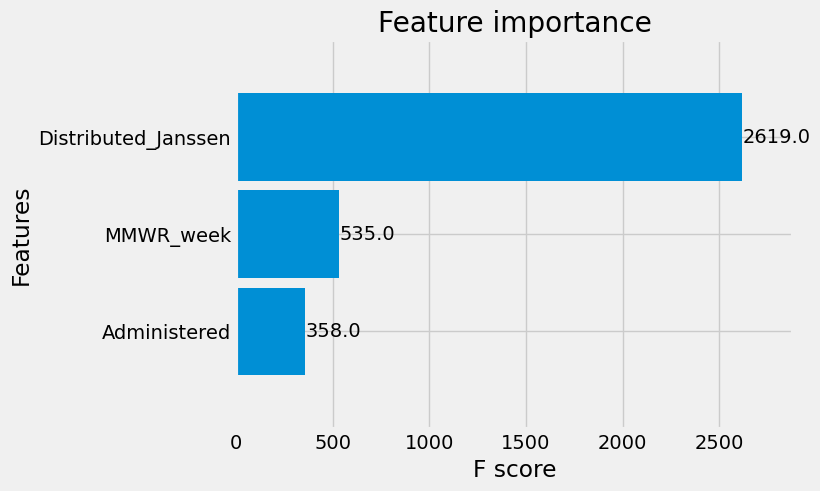

In [35]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

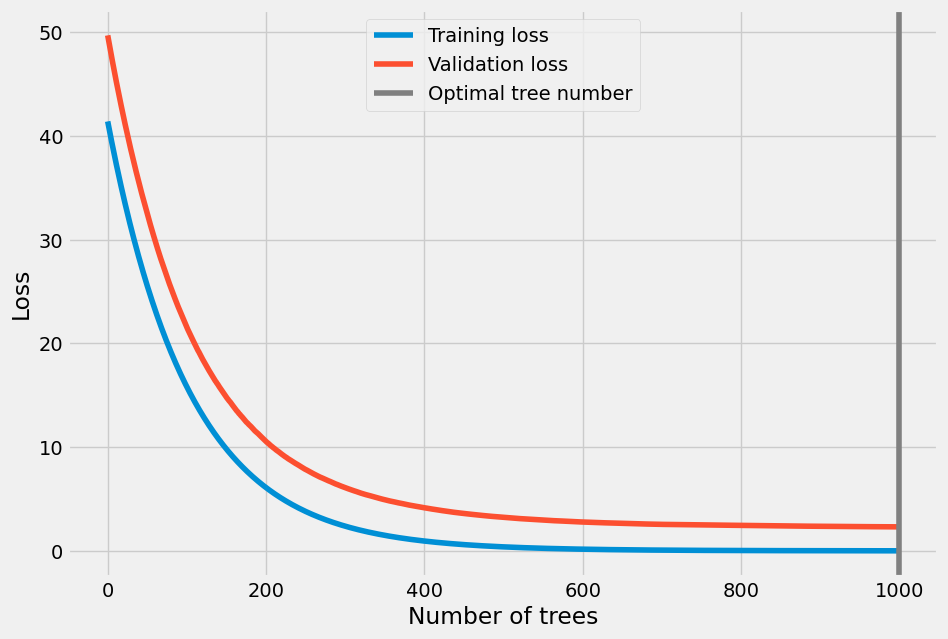

In [36]:
results = reg.evals_result()


plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

## Tuning grouped model

In [39]:
# Define hyperparameter search space
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV and fit
random_search = RandomizedSearchCV(
    reg, param_distributions=param_dist, n_iter=50,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=True, random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

RandomizedSearchCV(cv=TimeSeriesSplit(gap=12, max_train_size=None, n_splits=3, test_size=12),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_...
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': array([1, 2, 3, 4, 5]),
                                        'reg_alpha': array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01]),
                                        'reg_lambda': array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01]),
                                        'subsample': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=True)

In [40]:
# Print best parameters

print(f"Best parameters found: {random_search.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(random_search.best_score_))}")

Best parameters found: {'subsample': 0.625, 'reg_lambda': 0.00031622776601683794, 'reg_alpha': 10.0, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.5, 'colsample_bytree': 0.5}
Lowest RMSE found: 14.39051134416607


In [41]:
# Evaluate with cross-validation (xgb.cv)
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    random_search.best_params_,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

print(f"Final cross-validated RMSE: {cv_results['test-rmse-mean'].tail(1).values[0]}")


Final cross-validated RMSE: 2.5074706000000004


## Finer Randomized search

In [42]:
# Define hyperparameter search space
param_dist = {
    'learning_rate': [0.1, 0.2, 0.25, 0.3, 0.35],
    'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400, 500],
    'max_depth': [5,6,7,8,9],
    'min_child_weight': [3,4,5,6],
    'gamma': [0.4,0.45,0.5,0.55,0.6],
    'subsample': [0.6, 0.625, 0.75, 0.9],
    'colsample_bytree': [0.4,0.45,0.5,0.55,0.6],
    'reg_alpha': [8,9,10,11],
    'reg_lambda': [0.0002, 0.00031622776601683794, 0.0004]
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor()

# Initialize RandomizedSearchCV and fit
random_search = RandomizedSearchCV(
    reg, param_distributions=param_dist, n_iter=50,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=True, random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

RandomizedSearchCV(cv=TimeSeriesSplit(gap=12, max_train_size=None, n_splits=3, test_size=12),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_...
                                                             0.55, 0.6],
                                        'gamma': [0.4, 0.45, 0.5, 0.55, 0.6],
                                        'learning_rate': [0.1, 0.2, 0.25, 0.3,
                                                          0.35],
                                        'max_depth': [5, 6, 7, 8, 9],
                                        'min_child_weight': [3, 4, 5, 6],
                                        'n_estimators': [25, 50, 100, 150, 200,
                                                         250, 300, 400, 500],
                                        'reg_alpha': [8, 9, 10, 11],
                                        'reg_lambda': [0.0002,
                                                       0.00031622776601683794,
                                                       0.0004],
                                        'subsample': [0.6, 0.625, 0.75, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=True)

In [43]:
# Print best parameters

print(f"Best parameters found: {random_search.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(random_search.best_score_))}")

Best parameters found: {'subsample': 0.9, 'reg_lambda': 0.0002, 'reg_alpha': 10, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.55, 'colsample_bytree': 0.5}
Lowest RMSE found: 13.696897314640966


In [44]:
# Evaluate with cross-validation (xgb.cv)
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    random_search.best_params_,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

print(f"Final cross-validated RMSE: {cv_results['test-rmse-mean'].tail(1).values[0]}")


[17:24:28] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:24:28] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:24:28] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

# Scaling

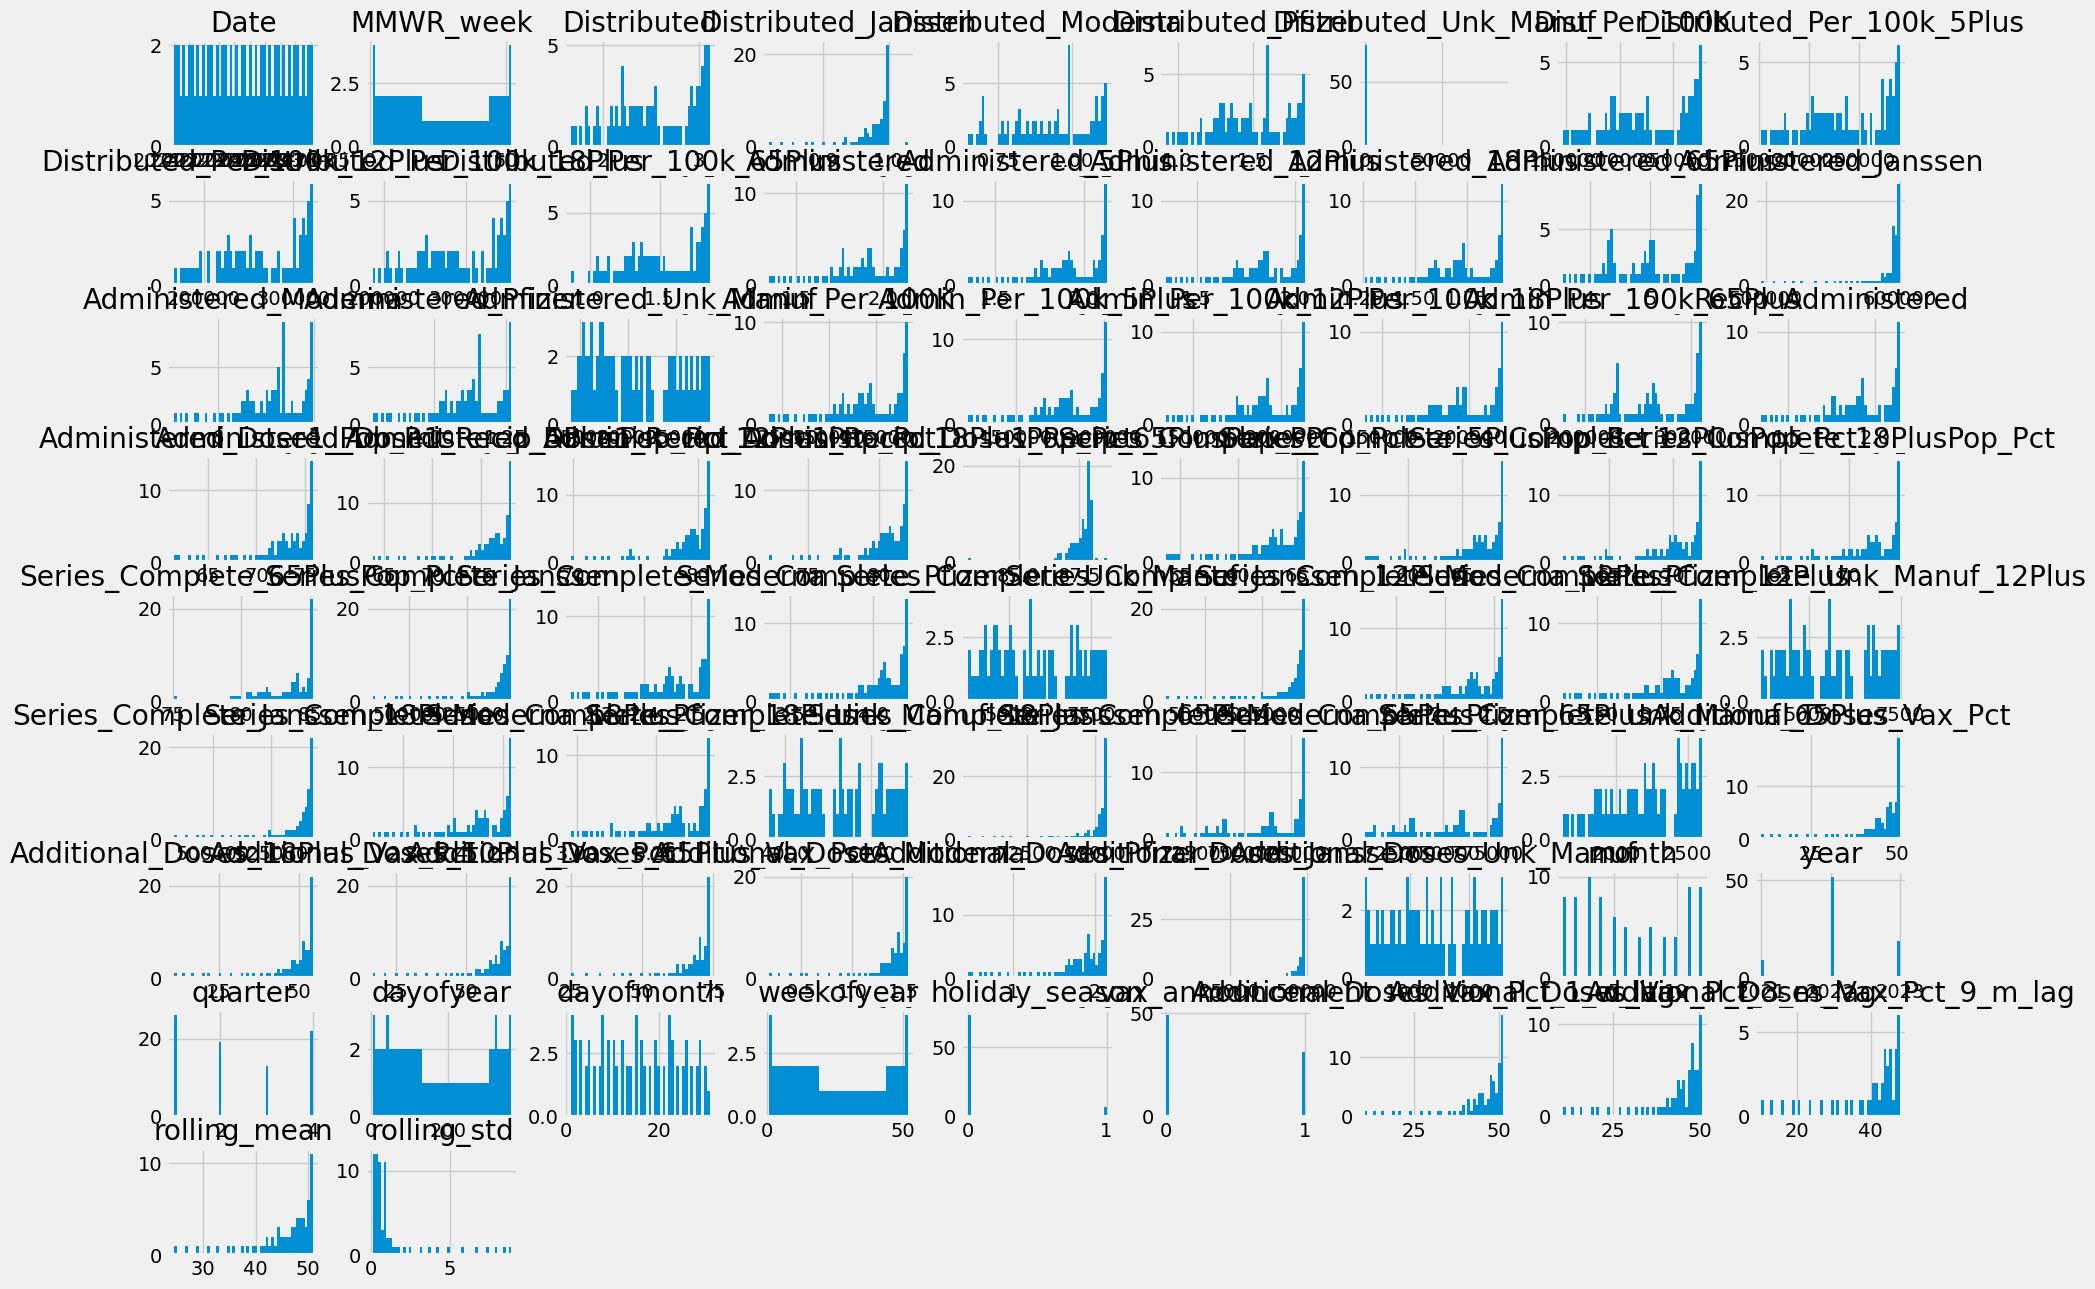

In [45]:
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20,15))
plt.show()


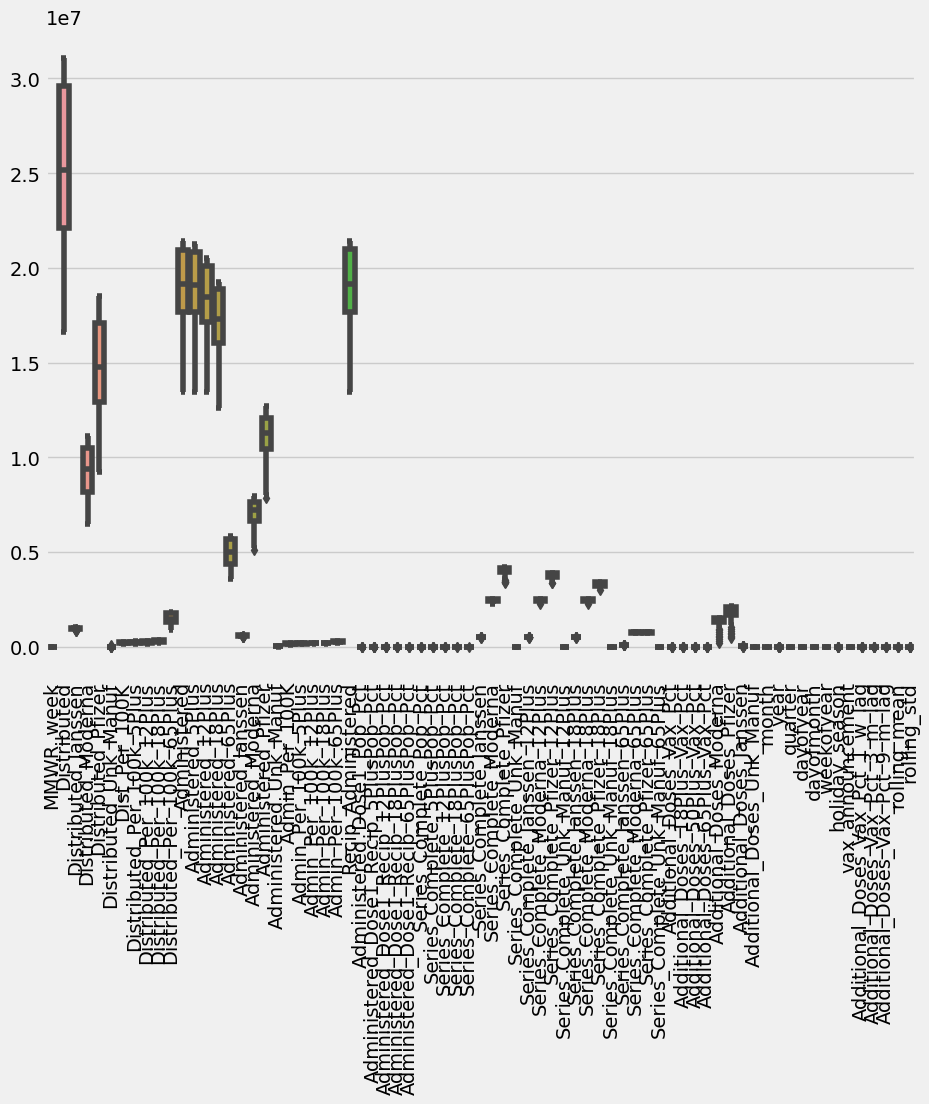

In [46]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()


I am going to scale my data because of the varying distributions of the features.

In [ ]:
# Set the name of the target variable
pred_var = 'Additional_Doses_Vax_Pct'

# Load the dataset from a CSV file into a pandas DataFrame
df = pd.read_csv('df_post_eda.csv')

# Convert the 'Date' column to datetime objects for proper time series manipulation
df['Date'] = pd.to_datetime(df['Date'])

# Group the data by 'Date' and compute the mean for each group/date 
# (useful becasue there are multiple entries per date)
df = df.groupby('Date').mean()

# Create a new DataFrame from the aggregated data
data = pd.DataFrame(df)

# # Resample the data to a weekly frequency, summing the values within each week
# # (this could aggregate the data if the original data is at a finer time scale than one week)
# data = data.resample('W').sum()

# Initialize an instance of MinMaxScaler that will scale features to the range [0, 1]
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the data, transforming all features to a scaled version
# and create a new DataFrame with these scaled values
df = pd.DataFrame(min_max_scaler.fit_transform(data), columns=data.columns, index=data.index).reset_index()


In [ ]:
# Additional time-series columns to account for 3-month pattern
# 3 month lag
df['Additional_Doses_Vax_Pct_3_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(12)

# 9 month lag
df['Additional_Doses_Vax_Pct_9_m_lag'] = df['Additional_Doses_Vax_Pct'].shift(36)

# Rolling statistics
df['rolling_mean'] = df[pred_var].shift().rolling(window=12).mean()
df['rolling_std'] = df[pred_var].shift().rolling(window=12).std()

# One-hot encoding of the entire dataframe
df_encoded = pd.get_dummies(df)

# Split the dataset based on unique dates
splits_by_date = [df_encoded[df_encoded['Date'] == date] for date in df_encoded['Date'].unique()]

# TimeSeriesSplit
# I made the test_size = 12 because I think a 3 month's worth of data is sufficient

tscv = TimeSeriesSplit(n_splits=3, test_size = 12, gap = 12)

for train_index, test_index in tscv.split(splits_by_date):
    train = pd.concat([splits_by_date[i] for i in train_index])
    test = pd.concat([splits_by_date[i] for i in test_index])
    
# Split into train and test sets
split_index = int(len(df) * 0.7)
train = df.iloc[:split_index]
test = df.iloc[split_index:]

# Set up XGBoost data structures and dropping Date column because it cannot be used directly
X_train, y_train = train.drop([pred_var, 'Date', 'Distributed'], axis=1), train[pred_var]
X_test, y_test = test.drop([pred_var, 'Date', 'Distributed'], axis=1), test[pred_var]

In [93]:
reg = xgb.XGBRegressor(learning_rate=0.01,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[00:35:12] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:0.34914	validation_1-rmse:0.48622
[1]	validation_0-rmse:0.34589	validation_1-rmse:0.48335
[2]	validation_0-rmse:0.34268	validation_1-rmse:0.48053
[3]	validation_0-rmse:0.33949	validation_1-rmse:0.47768
[4]	validation_0-rmse:0.33634	validation_1-rmse:0.47492
[5]	validation_0-rmse:0.33322	validation_1-rmse:0.47213
[6]	validation_0-rmse:0.33012	validation_1-rmse:0.46946
[7]	validation_0-rmse:0.32706	validation_1-rmse:0.46681
[8]	validation_0-rmse:0.32403	validation_1-rmse:0.46411
[9]	validation_0-rmse:0.32103	validation_1-rmse:0.46151
[10]	validation_0-rmse:0.31805	validation_1-rmse:0.45895
[11]	valida

[137]	validation_0-rmse:0.09994	validation_1-rmse:0.28328
[138]	validation_0-rmse:0.09906	validation_1-rmse:0.28247
[139]	validation_0-rmse:0.09818	validation_1-rmse:0.28165
[140]	validation_0-rmse:0.09731	validation_1-rmse:0.28085
[141]	validation_0-rmse:0.09645	validation_1-rmse:0.28003
[142]	validation_0-rmse:0.09559	validation_1-rmse:0.27925
[143]	validation_0-rmse:0.09475	validation_1-rmse:0.27845
[144]	validation_0-rmse:0.09391	validation_1-rmse:0.27767
[145]	validation_0-rmse:0.09309	validation_1-rmse:0.27688
[146]	validation_0-rmse:0.09226	validation_1-rmse:0.27610
[147]	validation_0-rmse:0.09145	validation_1-rmse:0.27537
[148]	validation_0-rmse:0.09065	validation_1-rmse:0.27460
[149]	validation_0-rmse:0.08985	validation_1-rmse:0.27387
[150]	validation_0-rmse:0.08906	validation_1-rmse:0.27311
[151]	validation_0-rmse:0.08828	validation_1-rmse:0.27238
[152]	validation_0-rmse:0.08750	validation_1-rmse:0.27162
[153]	validation_0-rmse:0.08673	validation_1-rmse:0.27093
[154]	validati

[279]	validation_0-rmse:0.02999	validation_1-rmse:0.20545
[280]	validation_0-rmse:0.02975	validation_1-rmse:0.20513
[281]	validation_0-rmse:0.02952	validation_1-rmse:0.20477
[282]	validation_0-rmse:0.02928	validation_1-rmse:0.20442
[283]	validation_0-rmse:0.02905	validation_1-rmse:0.20419
[284]	validation_0-rmse:0.02883	validation_1-rmse:0.20397
[285]	validation_0-rmse:0.02860	validation_1-rmse:0.20373
[286]	validation_0-rmse:0.02838	validation_1-rmse:0.20350
[287]	validation_0-rmse:0.02815	validation_1-rmse:0.20317
[288]	validation_0-rmse:0.02794	validation_1-rmse:0.20287
[289]	validation_0-rmse:0.02772	validation_1-rmse:0.20267
[290]	validation_0-rmse:0.02750	validation_1-rmse:0.20246
[291]	validation_0-rmse:0.02729	validation_1-rmse:0.20225
[292]	validation_0-rmse:0.02707	validation_1-rmse:0.20204
[293]	validation_0-rmse:0.02686	validation_1-rmse:0.20184
[294]	validation_0-rmse:0.02666	validation_1-rmse:0.20164
[295]	validation_0-rmse:0.02645	validation_1-rmse:0.20144
[296]	validati

[421]	validation_0-rmse:0.01067	validation_1-rmse:0.18302
[422]	validation_0-rmse:0.01060	validation_1-rmse:0.18295
[423]	validation_0-rmse:0.01053	validation_1-rmse:0.18289
[424]	validation_0-rmse:0.01046	validation_1-rmse:0.18283
[425]	validation_0-rmse:0.01039	validation_1-rmse:0.18276
[426]	validation_0-rmse:0.01032	validation_1-rmse:0.18270
[427]	validation_0-rmse:0.01025	validation_1-rmse:0.18264
[428]	validation_0-rmse:0.01018	validation_1-rmse:0.18258
[429]	validation_0-rmse:0.01012	validation_1-rmse:0.18252
[430]	validation_0-rmse:0.01005	validation_1-rmse:0.18246
[431]	validation_0-rmse:0.00999	validation_1-rmse:0.18240
[432]	validation_0-rmse:0.00992	validation_1-rmse:0.18234
[433]	validation_0-rmse:0.00985	validation_1-rmse:0.18228
[434]	validation_0-rmse:0.00979	validation_1-rmse:0.18222
[435]	validation_0-rmse:0.00972	validation_1-rmse:0.18216
[436]	validation_0-rmse:0.00966	validation_1-rmse:0.18210
[437]	validation_0-rmse:0.00960	validation_1-rmse:0.18204
[438]	validati

[563]	validation_0-rmse:0.00447	validation_1-rmse:0.17835
[564]	validation_0-rmse:0.00444	validation_1-rmse:0.17833
[565]	validation_0-rmse:0.00441	validation_1-rmse:0.17831
[566]	validation_0-rmse:0.00439	validation_1-rmse:0.17828
[567]	validation_0-rmse:0.00436	validation_1-rmse:0.17826
[568]	validation_0-rmse:0.00434	validation_1-rmse:0.17824
[569]	validation_0-rmse:0.00432	validation_1-rmse:0.17822
[570]	validation_0-rmse:0.00429	validation_1-rmse:0.17820
[571]	validation_0-rmse:0.00427	validation_1-rmse:0.17817
[572]	validation_0-rmse:0.00424	validation_1-rmse:0.17815
[573]	validation_0-rmse:0.00422	validation_1-rmse:0.17813
[574]	validation_0-rmse:0.00419	validation_1-rmse:0.17811
[575]	validation_0-rmse:0.00417	validation_1-rmse:0.17809
[576]	validation_0-rmse:0.00415	validation_1-rmse:0.17807
[577]	validation_0-rmse:0.00412	validation_1-rmse:0.17805
[578]	validation_0-rmse:0.00410	validation_1-rmse:0.17803
[579]	validation_0-rmse:0.00408	validation_1-rmse:0.17801
[580]	validati

[705]	validation_0-rmse:0.00207	validation_1-rmse:0.17544
[706]	validation_0-rmse:0.00206	validation_1-rmse:0.17542
[707]	validation_0-rmse:0.00205	validation_1-rmse:0.17539
[708]	validation_0-rmse:0.00204	validation_1-rmse:0.17537
[709]	validation_0-rmse:0.00203	validation_1-rmse:0.17534
[710]	validation_0-rmse:0.00202	validation_1-rmse:0.17532
[711]	validation_0-rmse:0.00201	validation_1-rmse:0.17530
[712]	validation_0-rmse:0.00200	validation_1-rmse:0.17527
[713]	validation_0-rmse:0.00199	validation_1-rmse:0.17525
[714]	validation_0-rmse:0.00198	validation_1-rmse:0.17523
[715]	validation_0-rmse:0.00197	validation_1-rmse:0.17520
[716]	validation_0-rmse:0.00196	validation_1-rmse:0.17518
[717]	validation_0-rmse:0.00195	validation_1-rmse:0.17516
[718]	validation_0-rmse:0.00194	validation_1-rmse:0.17513
[719]	validation_0-rmse:0.00193	validation_1-rmse:0.17511
[720]	validation_0-rmse:0.00192	validation_1-rmse:0.17509
[721]	validation_0-rmse:0.00191	validation_1-rmse:0.17507
[722]	validati

[847]	validation_0-rmse:0.00101	validation_1-rmse:0.17303
[848]	validation_0-rmse:0.00101	validation_1-rmse:0.17302
[849]	validation_0-rmse:0.00100	validation_1-rmse:0.17301
[850]	validation_0-rmse:0.00100	validation_1-rmse:0.17300
[851]	validation_0-rmse:0.00099	validation_1-rmse:0.17299
[852]	validation_0-rmse:0.00099	validation_1-rmse:0.17298
[853]	validation_0-rmse:0.00098	validation_1-rmse:0.17297
[854]	validation_0-rmse:0.00098	validation_1-rmse:0.17295
[855]	validation_0-rmse:0.00097	validation_1-rmse:0.17294
[856]	validation_0-rmse:0.00097	validation_1-rmse:0.17294
[857]	validation_0-rmse:0.00096	validation_1-rmse:0.17292
[858]	validation_0-rmse:0.00096	validation_1-rmse:0.17291
[859]	validation_0-rmse:0.00095	validation_1-rmse:0.17290
[860]	validation_0-rmse:0.00095	validation_1-rmse:0.17289
[861]	validation_0-rmse:0.00094	validation_1-rmse:0.17288
[862]	validation_0-rmse:0.00094	validation_1-rmse:0.17287
[863]	validation_0-rmse:0.00093	validation_1-rmse:0.17286
[864]	validati

[989]	validation_0-rmse:0.00052	validation_1-rmse:0.17192
[990]	validation_0-rmse:0.00051	validation_1-rmse:0.17191
[991]	validation_0-rmse:0.00051	validation_1-rmse:0.17190
[992]	validation_0-rmse:0.00051	validation_1-rmse:0.17190
[993]	validation_0-rmse:0.00051	validation_1-rmse:0.17189
[994]	validation_0-rmse:0.00051	validation_1-rmse:0.17189
[995]	validation_0-rmse:0.00050	validation_1-rmse:0.17189
[996]	validation_0-rmse:0.00050	validation_1-rmse:0.17188
[997]	validation_0-rmse:0.00050	validation_1-rmse:0.17188
[998]	validation_0-rmse:0.00050	validation_1-rmse:0.17187
[999]	validation_0-rmse:0.00049	validation_1-rmse:0.17187


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [94]:
# Forecasting and Evaluation
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Compute RMSE
train_rmse = np.sqrt(np.mean((train_pred - y_train)**2))
print(f"Train RMSE: {train_rmse}")

test_rmse = np.sqrt(np.mean((test_pred - y_test)**2))
print(f"Test RMSE: {test_rmse}")

Train RMSE: 0.0004950183484052379
Test RMSE: 0.17187220816222243


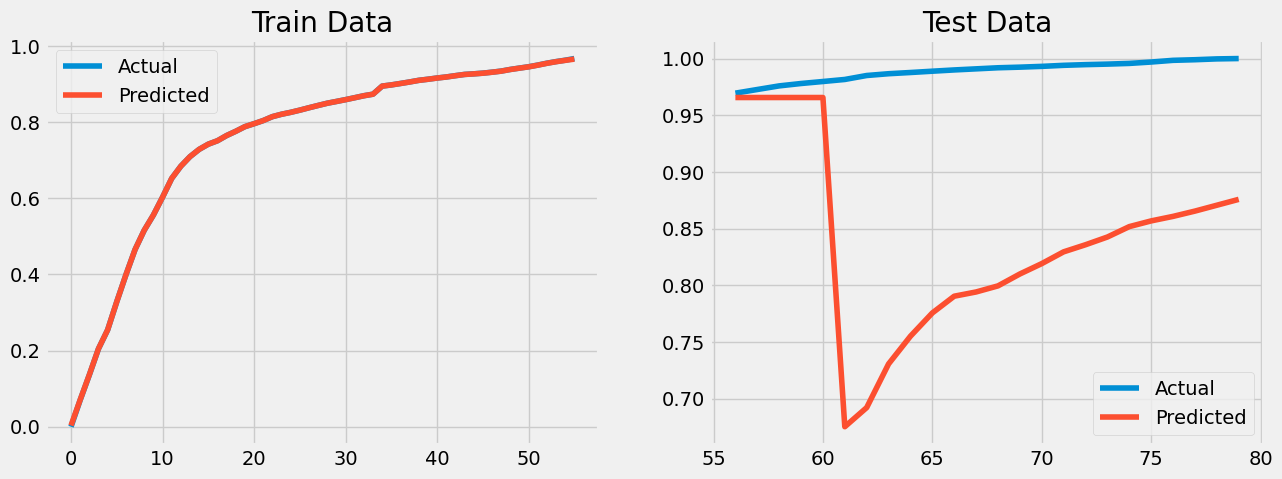

Train RMSE: 0.0004950183484052379
Test RMSE: 0.17187220816222243


In [95]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_pred, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_pred, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()

# Show the plots
plt.show()

# Print RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

## Tuning grouped, scaled model

In [63]:
# Define hyperparameter search space
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400, 500, 1000],
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV and fit
random_search = RandomizedSearchCV(
    reg, param_distributions=param_dist, n_iter=50,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=True, random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

RandomizedSearchCV(cv=TimeSeriesSplit(gap=12, max_train_size=None, n_splits=3, test_size=12),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_...
                                        'n_estimators': [25, 50, 100, 150, 200,
                                                         250, 300, 400, 500,
                                                         1000],
                                        'reg_alpha': array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01]),
                                        'reg_lambda': array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01]),
                                        'subsample': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=True)

In [64]:
# Print best parameters

print(f"Best parameters found: {random_search.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(random_search.best_score_))}")

Best parameters found: {'subsample': 1.0, 'reg_lambda': 1e-05, 'reg_alpha': 0.00031622776601683794, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.5}
Lowest RMSE found: 0.36313057151516437


In [65]:
# Evaluate with cross-validation (xgb.cv)
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    random_search.best_params_,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

print(f"Final cross-validated RMSE: {cv_results['test-rmse-mean'].tail(1).values[0]}")


[17:46:28] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:46:28] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[17:46:28] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

In [68]:
# Get the best estimator from the search
best_model = random_search.best_estimator_

# Predict on the training data
train_preds = best_model.predict(X_train)

# Predict on the testing data
test_preds = best_model.predict(X_test)

# Calculate the RMSE for the train and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
test_rmse = sqrt(mean_squared_error(y_test, test_preds))

# Print RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 0.01008127786343595
Test RMSE: 0.10919308156305647


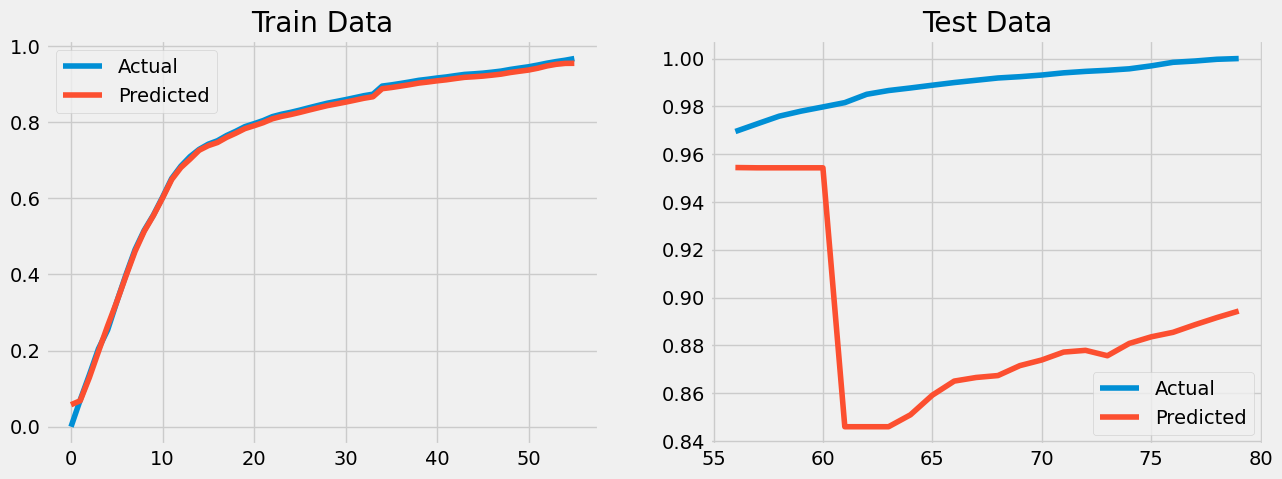

Train RMSE: 0.01008127786343595
Test RMSE: 0.10919308156305647


In [97]:
# Best parameters
params = {
    'subsample': 1.0,
    'reg_lambda': 1e-05,
    'reg_alpha': 0.00031622776601683794,
    'min_child_weight': 3,
    'max_depth': 9,
    'learning_rate': 0.01,
    'gamma': 0.0,
    'colsample_bytree': 0.5,
    'n_estimators': 400
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(**params)

# Fit the model
reg.fit(X_train, y_train)

# Make predictions
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Calculate RMSE for train and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_pred))
test_rmse = sqrt(mean_squared_error(y_test, test_pred))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_pred, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_pred, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()

# Show the plots
plt.show()

# Print RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


## Grid Search for finer tuning

In [73]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [25, 50, 100, 300, 350, 400, 450, 500, 1000],
    'max_depth': [7, 8, 9, 10, 11],
}

# Initialize XGBoost regressor with some parameters found in randomized search
reg = XGBRegressor(
    subsample=1.0,
    reg_lambda=1e-05,
    reg_alpha=0.00031622776601683794,
    min_child_weight=3,
    gamma=0.0,
    colsample_bytree=0.5
)


# Initialize GridSearchCV and fit
grid_search = GridSearchCV(
    reg, param_grid=param_grid,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=True
)

grid_search.fit(X_train, y_train)

# Get the best estimator from the search
best_model = grid_search.best_estimator_

# Predict on the training data
train_preds = best_model.predict(X_train)

# Predict on the testing data
test_preds = best_model.predict(X_test)

# Calculate the RMSE for the train and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
test_rmse = sqrt(mean_squared_error(y_test, test_preds))

# Print the best parameters, train RMSE and test RMSE
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Fitting 3 folds for each of 225 candidates, totalling 675 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

Best parameters found: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}
Train RMSE: 0.0008249297707994798
Test RMSE: 0.06809394403636815


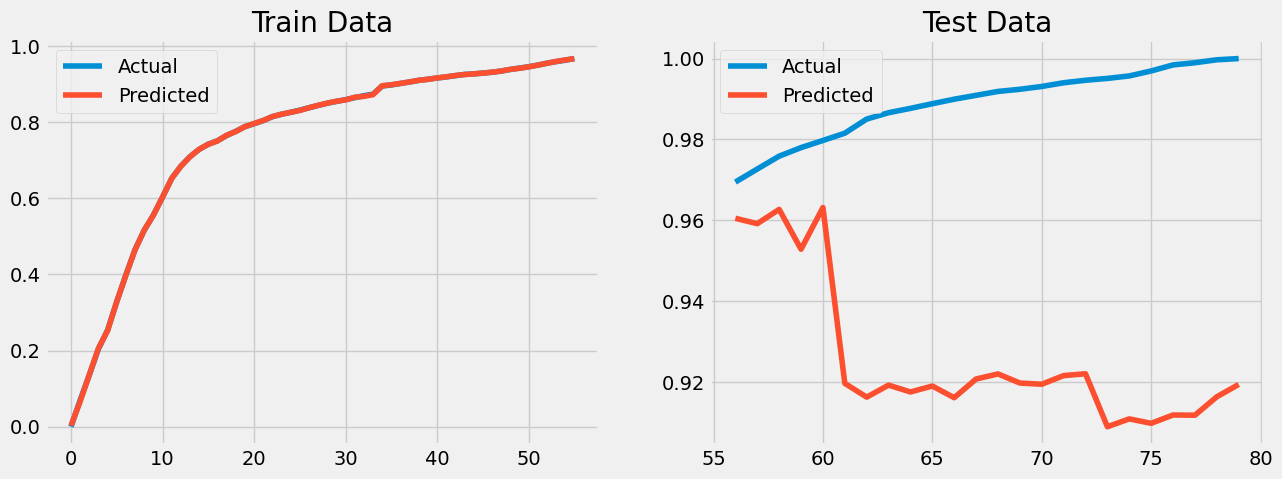

Train RMSE: 0.0008249297707994798
Test RMSE: 0.06809394403636815


In [98]:
# Best parameters
params = {
    'subsample': 1.0,
    'reg_lambda': 1e-05,
    'reg_alpha': 0.00031622776601683794,
    'min_child_weight': 3,
    'max_depth': 7,
    'learning_rate': 0.3,
    'gamma': 0.0,
    'colsample_bytree': 0.5,
    'n_estimators': 300
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(**params)

# Fit the model
reg.fit(X_train, y_train)

# Make predictions
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Calculate RMSE for train and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_pred))
test_rmse = sqrt(mean_squared_error(y_test, test_pred))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_pred, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_pred, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()

# Show the plots
plt.show()

# Print RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


In [99]:
# Get the best estimator from the search
best_model = grid_search.best_estimator_

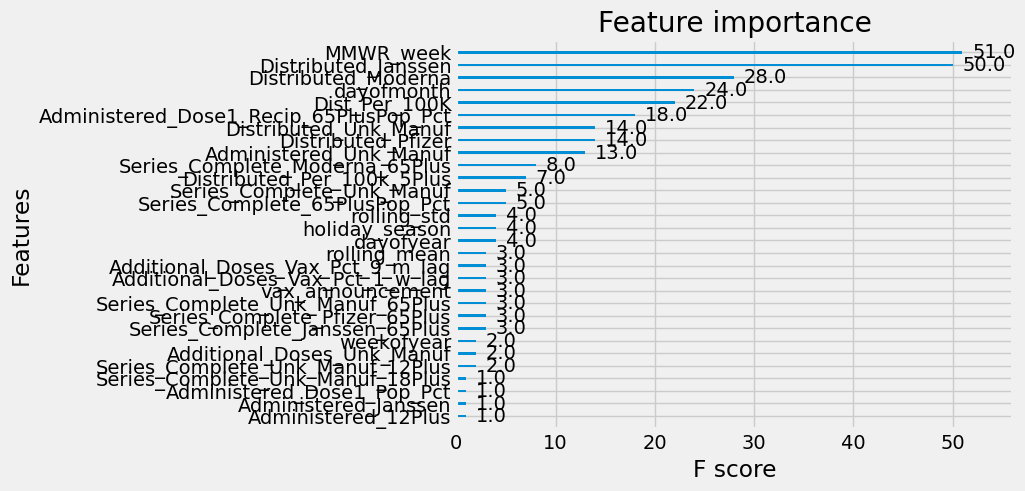

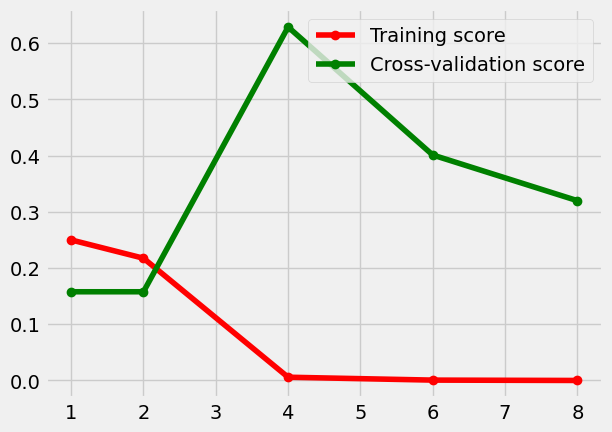

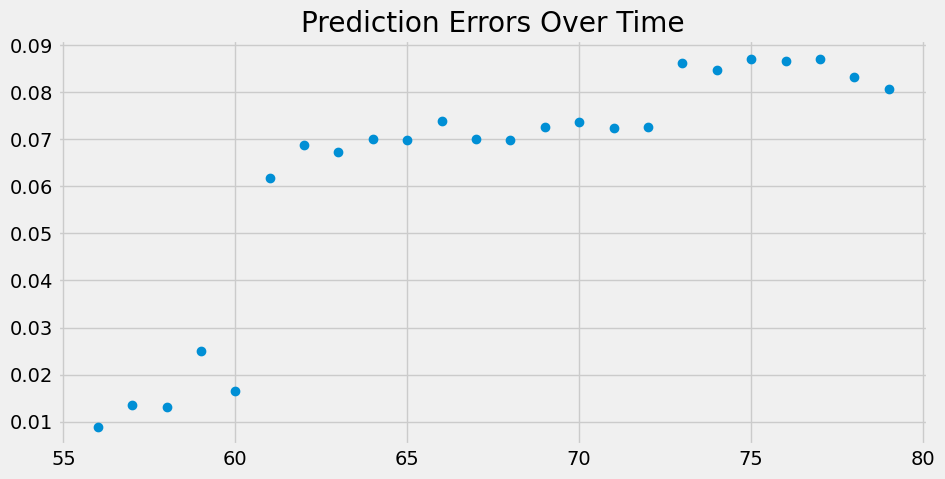

In [100]:
from xgboost import plot_importance
from sklearn.model_selection import learning_curve

# Plot feature importances
plot_importance(best_model)
plt.show()

# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

# Error analysis
errors = y_test - test_preds
plt.figure(figsize=(10, 5))
plt.plot(errors.index, errors.values, marker='o', linestyle='')
plt.title('Prediction Errors Over Time')
plt.show()


## Grid search for regularization params [RUN]

In [ ]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.2, 0.3],
    'n_estimators': [300, 350, 1000],
    'max_depth': [7, 8],
    'gamma': [0.0, 0.25,0.5,0.55],
    'reg_alpha': [0,0.00031622776601683794,10],
    'reg_lambda': [1e-05, 1, 0.316]
}

# Initialize XGBoost regressor with some parameters found in randomized search
reg = XGBRegressor(
    subsample=1.0,
    min_child_weight=3,
    colsample_bytree=0.5
)


# Initialize GridSearchCV and fit
grid_search1 = GridSearchCV(
    reg, param_grid=param_grid,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=True
)

grid_search1.fit(X_train, y_train)

# Get the best estimator from the search
best_model1 = grid_search1.best_estimator_

# Predict on the training data
train_preds = best_model1.predict(X_train)

# Predict on the testing data
test_preds = best_model1.predict(X_test)

# Calculate the RMSE for the train and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
test_rmse = sqrt(mean_squared_error(y_test, test_preds))

In [ ]:
# Print the best parameters, train RMSE and test RMSE
print(f"Best parameters found: {grid_search1.best_params_}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

In [ ]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_preds, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_preds, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()
ax[1].set_ylim(0, 1.5)  # Set the y-axis to range from 0 to 1

# Show the plots
plt.show()

In [ ]:
# Plot feature importances
plot_importance(best_model1, max_num_features = 5)
plt.show()

# Scaled, no grouping
## Initial model

In [54]:
# Load the dataset
df = pd.read_csv('df_post_eda.csv')

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Save the 'Date' column and drop it from the DataFrame
date_column = df['Date']
df.drop('Date', axis=1, inplace=True)

# Apply one-hot encoding to the DataFrame
df_encoded = pd.get_dummies(df)

# Initialize an instance of MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))

# Apply the scaler to the encoded data
df_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_encoded), columns=df_encoded.columns)

# Re-attach the 'Date' column
df_scaled['Date'] = date_column

# Reorder the columns to place 'Date' at the start
df_scaled = df_scaled[['Date'] + [col for col in df_scaled.columns if col != 'Date']]

# Display the first few rows of the modified DataFrame
df_scaled.head()


,Date,MMWR_week,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,Distributed_Per_100k_12Plus,...,Location_WI,Location_WV,Location_WY,day_of_week_Wednesday,season_fall,season_spring,season_summer,season_winter,holidays_Holiday,holidays_Normal day
0,2023-05-10,0.352941,0.005535,0.004671,0.004618,0.004949,0.0,0.683002,0.698473,0.721250,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,2023-05-10,0.352941,0.010411,0.010152,0.010752,0.008801,0.0,0.533085,0.543521,0.557723,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2023-05-10,0.352941,0.029149,0.026726,0.027659,0.025187,0.0,0.652127,0.662762,0.680174,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,2023-05-10,0.352941,0.001268,0.001499,0.001332,0.000993,0.0,0.533779,0.541625,0.555853,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,2023-05-10,0.352941,0.018017,0.015426,0.015280,0.015392,0.0,0.743694,0.752488,0.766083,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [55]:
# Additional time-series columns to account for 3-month pattern
# 3 month lag
df_scaled['Additional_Doses_Vax_Pct_3_m_lag'] = df_scaled['Additional_Doses_Vax_Pct'].shift(12)

# 9 month lag
df_scaled['Additional_Doses_Vax_Pct_9_m_lag'] = df_scaled['Additional_Doses_Vax_Pct'].shift(36)

# 1 week lag (because ACF plot said to)
df_scaled['Additional_Doses_Vax_Pct_1_w_lag'] = df_scaled['Additional_Doses_Vax_Pct'].shift(1)

# Rolling statistics
df_scaled['rolling_mean'] = df_scaled[pred_var].shift().rolling(window=12).mean()
df_scaled['rolling_std'] = df_scaled[pred_var].shift().rolling(window=12).std()

# Split the dataset based on unique dates
splits_by_date = [df_scaled[df_scaled['Date'] == date] for date in df_scaled['Date'].unique()]

# TimeSeriesSplit
# I made the test_size = 12 because I think a 3 month's worth of data is sufficient

tscv = TimeSeriesSplit(n_splits=3, test_size = 12, gap = 12)

for train_index, test_index in tscv.split(splits_by_date):
    train = pd.concat([splits_by_date[i] for i in train_index])
    test = pd.concat([splits_by_date[i] for i in test_index])
    
# Split into train and test sets
split_index = int(len(df_scaled) * 0.7)
train = df_scaled.iloc[:split_index]
test = df_scaled.iloc[split_index:]

# Set up XGBoost data structures and dropping 'Date' because XGBoost cannot handle it
X_train, y_train = train.drop([pred_var, 'Date'], axis=1), train[pred_var]
X_test, y_test = test.drop([pred_var, 'Date'], axis=1), test[pred_var]

In [56]:
reg_base = xgb.XGBRegressor(learning_rate=0.01,n_estimators=1000, early_stopping_rounds=10)
reg_base.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

[22:31:44] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:0.25171	validation_1-rmse:0.20518
[1]	validation_0-rmse:0.24921	validation_1-rmse:0.20344
[2]	validation_0-rmse:0.24674	validation_1-rmse:0.20173
[3]	validation_0-rmse:0.24430	validation_1-rmse:0.20004
[4]	validation_0-rmse:0.24188	validation_1-rmse:0.19836
[5]	validation_0-rmse:0.23949	validation_1-rmse:0.19668
[6]	validation_0-rmse:0.23711	validation_1-rmse:0.19505
[7]	validation_0-rmse:0.23477	validation_1-rmse:0.19343
[8]	validation_0-rmse:0.23244	validation_1-rmse:0.19182
[9]	validation_0-rmse:0.23014	validation_1-rmse:0.19022
[10]	validation_0-rmse:0.22786	validation_1-rmse:0.18865
[11]	valida

[137]	validation_0-rmse:0.06465	validation_1-rmse:0.08674
[138]	validation_0-rmse:0.06402	validation_1-rmse:0.08648
[139]	validation_0-rmse:0.06339	validation_1-rmse:0.08623
[140]	validation_0-rmse:0.06276	validation_1-rmse:0.08594
[141]	validation_0-rmse:0.06215	validation_1-rmse:0.08569
[142]	validation_0-rmse:0.06154	validation_1-rmse:0.08544
[143]	validation_0-rmse:0.06093	validation_1-rmse:0.08517
[144]	validation_0-rmse:0.06034	validation_1-rmse:0.08490
[145]	validation_0-rmse:0.05974	validation_1-rmse:0.08467
[146]	validation_0-rmse:0.05916	validation_1-rmse:0.08445
[147]	validation_0-rmse:0.05858	validation_1-rmse:0.08420
[148]	validation_0-rmse:0.05800	validation_1-rmse:0.08398
[149]	validation_0-rmse:0.05743	validation_1-rmse:0.08376
[150]	validation_0-rmse:0.05687	validation_1-rmse:0.08358
[151]	validation_0-rmse:0.05631	validation_1-rmse:0.08334
[152]	validation_0-rmse:0.05576	validation_1-rmse:0.08311
[153]	validation_0-rmse:0.05521	validation_1-rmse:0.08289
[154]	validati

[279]	validation_0-rmse:0.01618	validation_1-rmse:0.07193
[280]	validation_0-rmse:0.01603	validation_1-rmse:0.07187
[281]	validation_0-rmse:0.01587	validation_1-rmse:0.07181
[282]	validation_0-rmse:0.01572	validation_1-rmse:0.07176
[283]	validation_0-rmse:0.01557	validation_1-rmse:0.07170
[284]	validation_0-rmse:0.01542	validation_1-rmse:0.07165
[285]	validation_0-rmse:0.01528	validation_1-rmse:0.07160
[286]	validation_0-rmse:0.01513	validation_1-rmse:0.07154
[287]	validation_0-rmse:0.01499	validation_1-rmse:0.07149
[288]	validation_0-rmse:0.01485	validation_1-rmse:0.07143
[289]	validation_0-rmse:0.01471	validation_1-rmse:0.07138
[290]	validation_0-rmse:0.01457	validation_1-rmse:0.07133
[291]	validation_0-rmse:0.01443	validation_1-rmse:0.07128
[292]	validation_0-rmse:0.01429	validation_1-rmse:0.07124
[293]	validation_0-rmse:0.01416	validation_1-rmse:0.07119
[294]	validation_0-rmse:0.01402	validation_1-rmse:0.07114
[295]	validation_0-rmse:0.01389	validation_1-rmse:0.07109
[296]	validati

[421]	validation_0-rmse:0.00446	validation_1-rmse:0.06731
[422]	validation_0-rmse:0.00443	validation_1-rmse:0.06729
[423]	validation_0-rmse:0.00439	validation_1-rmse:0.06729
[424]	validation_0-rmse:0.00435	validation_1-rmse:0.06727
[425]	validation_0-rmse:0.00432	validation_1-rmse:0.06726
[426]	validation_0-rmse:0.00428	validation_1-rmse:0.06724
[427]	validation_0-rmse:0.00425	validation_1-rmse:0.06723
[428]	validation_0-rmse:0.00421	validation_1-rmse:0.06722
[429]	validation_0-rmse:0.00418	validation_1-rmse:0.06721
[430]	validation_0-rmse:0.00415	validation_1-rmse:0.06720
[431]	validation_0-rmse:0.00411	validation_1-rmse:0.06719
[432]	validation_0-rmse:0.00408	validation_1-rmse:0.06718
[433]	validation_0-rmse:0.00405	validation_1-rmse:0.06717
[434]	validation_0-rmse:0.00402	validation_1-rmse:0.06716
[435]	validation_0-rmse:0.00398	validation_1-rmse:0.06715
[436]	validation_0-rmse:0.00395	validation_1-rmse:0.06714
[437]	validation_0-rmse:0.00392	validation_1-rmse:0.06712
[438]	validati

[563]	validation_0-rmse:0.00183	validation_1-rmse:0.06639
[564]	validation_0-rmse:0.00182	validation_1-rmse:0.06639
[565]	validation_0-rmse:0.00181	validation_1-rmse:0.06638
[566]	validation_0-rmse:0.00181	validation_1-rmse:0.06638
[567]	validation_0-rmse:0.00180	validation_1-rmse:0.06638
[568]	validation_0-rmse:0.00179	validation_1-rmse:0.06638
[569]	validation_0-rmse:0.00178	validation_1-rmse:0.06638
[570]	validation_0-rmse:0.00178	validation_1-rmse:0.06638
[571]	validation_0-rmse:0.00177	validation_1-rmse:0.06638
[572]	validation_0-rmse:0.00176	validation_1-rmse:0.06638
[573]	validation_0-rmse:0.00176	validation_1-rmse:0.06638
[574]	validation_0-rmse:0.00175	validation_1-rmse:0.06638
[575]	validation_0-rmse:0.00175	validation_1-rmse:0.06638
[576]	validation_0-rmse:0.00174	validation_1-rmse:0.06637
[577]	validation_0-rmse:0.00173	validation_1-rmse:0.06637
[578]	validation_0-rmse:0.00172	validation_1-rmse:0.06637
[579]	validation_0-rmse:0.00172	validation_1-rmse:0.06637
[580]	validati

[705]	validation_0-rmse:0.00130	validation_1-rmse:0.06628
[706]	validation_0-rmse:0.00130	validation_1-rmse:0.06628
[707]	validation_0-rmse:0.00130	validation_1-rmse:0.06628
[708]	validation_0-rmse:0.00130	validation_1-rmse:0.06628
[709]	validation_0-rmse:0.00129	validation_1-rmse:0.06628
[710]	validation_0-rmse:0.00129	validation_1-rmse:0.06627
[711]	validation_0-rmse:0.00129	validation_1-rmse:0.06627
[712]	validation_0-rmse:0.00129	validation_1-rmse:0.06627
[713]	validation_0-rmse:0.00129	validation_1-rmse:0.06627
[714]	validation_0-rmse:0.00129	validation_1-rmse:0.06627
[715]	validation_0-rmse:0.00128	validation_1-rmse:0.06627
[716]	validation_0-rmse:0.00128	validation_1-rmse:0.06627
[717]	validation_0-rmse:0.00128	validation_1-rmse:0.06627
[718]	validation_0-rmse:0.00128	validation_1-rmse:0.06627
[719]	validation_0-rmse:0.00128	validation_1-rmse:0.06627
[720]	validation_0-rmse:0.00128	validation_1-rmse:0.06627
[721]	validation_0-rmse:0.00128	validation_1-rmse:0.06627
[722]	validati

[847]	validation_0-rmse:0.00114	validation_1-rmse:0.06625
[848]	validation_0-rmse:0.00114	validation_1-rmse:0.06625
[849]	validation_0-rmse:0.00114	validation_1-rmse:0.06625
[850]	validation_0-rmse:0.00114	validation_1-rmse:0.06625
[851]	validation_0-rmse:0.00114	validation_1-rmse:0.06625
[852]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[853]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[854]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[855]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[856]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[857]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[858]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[859]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[860]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[861]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[862]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[863]	validation_0-rmse:0.00113	validation_1-rmse:0.06625
[864]	validati

[989]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[990]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[991]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[992]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[993]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[994]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[995]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[996]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[997]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[998]	validation_0-rmse:0.00107	validation_1-rmse:0.06621
[999]	validation_0-rmse:0.00107	validation_1-rmse:0.06621


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=10,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

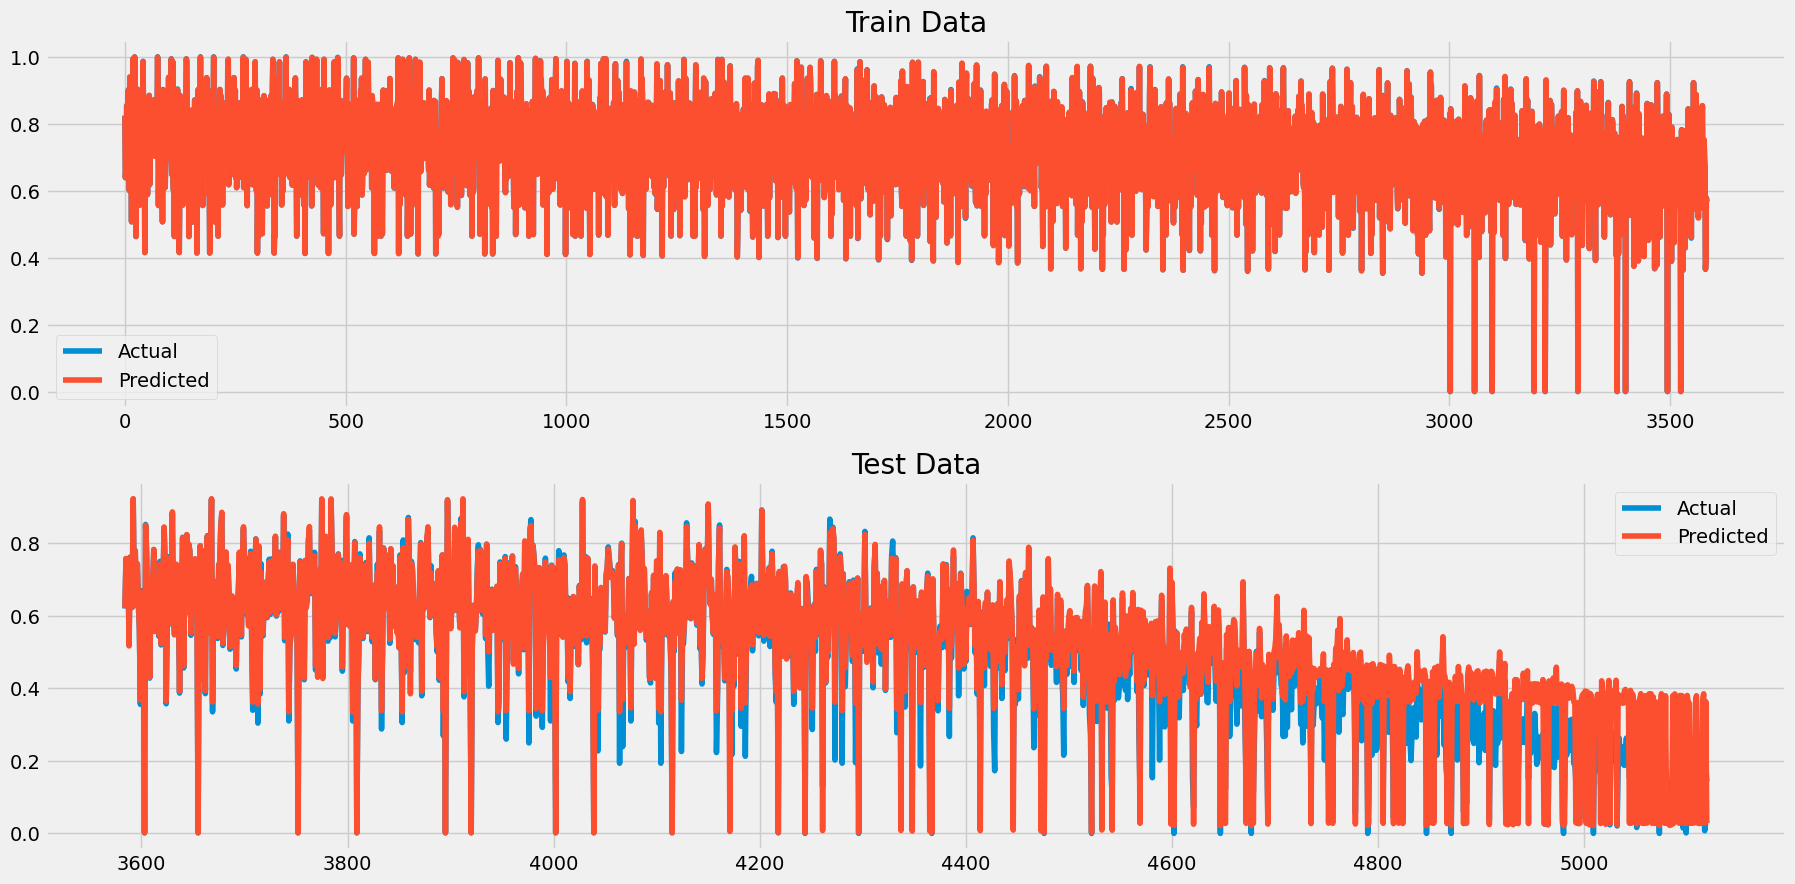

Train RMSE: 0.0005745397001864632
Test RMSE: 0.06604594797866337


In [57]:
# Forecasting and Evaluation
train_pred_base = reg_base.predict(X_train)
test_pred_base = reg_base.predict(X_test)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_pred_base, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_pred_base, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()

# Show the plots
plt.show()

# Print RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

### Feature selection from base model

In [59]:
# 1. Extract feature importances
importances = reg_base.feature_importances_

# 2. Determine a threshold
threshold = np.mean(importances)

# 3. Select features based on threshold
selection = SelectFromModel(reg_base, threshold=threshold, prefit=True)
X_train_selected_base = selection.transform(X_train)
X_test_selected_base = selection.transform(X_test)

# 4. Retrain model with selected features
selected_model_base = xgb.XGBRegressor(learning_rate=0.01, n_estimators=1000, early_stopping_rounds=10)
selected_model_base.fit(X_train_selected_base, y_train)

# 5. Evaluate the retrained model
train_pred_selected = selected_model_base.predict(X_train_selected_base)
test_pred_selected = selected_model_base.predict(X_test_selected_base)

# Calculate RMSE for the retrained model
train_rmse_selected = np.sqrt(mean_squared_error(y_train, train_pred_selected))
test_rmse_selected = np.sqrt(mean_squared_error(y_test, test_pred_selected))
print(f"Train RMSE with selected features: {train_rmse_selected}")
print(f"Test RMSE with selected features: {test_rmse_selected}")

# Print the number and names of selected features
selected_features = np.array(X_train.columns)[selection.get_support()]
print(f"Number of selected features: {len(selected_features)}")
print("Selected features:", selected_features)
# Print the parameters used in the selected_model_base
params_selected_model_base = selected_model_base.get_params()
print("Parameters used in the model:\n", params_selected_model_base)


[22:39:21] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Train RMSE with selected features: 0.001250234483955796
Test RMSE with selected features: 0.06285206040645482
Number of selected features: 11
Selected features: ['Distributed' 'Distributed_Janssen' 'Distributed_Per_100k_65Plus'
 'Administered' 'Administered_Janssen' 'Administered_Pfizer'
 'Administered_Dose1_Recip_65PlusPop_Pct' 'Series_Complete_Janssen'
 'Series_Complete_Unk_Manuf_12Plus' 'Additional_Doses_18Plus_Vax_Pct'
 'Additional_Doses_65Plus_Vax_Pct']
Parameters used in the model:
 {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_by

In [48]:
# Define the hyperparameter space
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400, 500, 1000],
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV
random_search_b = RandomizedSearchCV(
    estimator=xgb_reg, 
    param_distributions=param_dist, 
    n_iter=100, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Perform the tuning
random_search_b.fit(X_train_selected_base, y_train)
 
# Evaluate the best model
best_model_fs_b = random_search_b.best_estimator_
train_pred = best_model_fs_b.predict(X_train_selected_base)
test_pred = best_model_fs_b.predict(X_test_selected_base)

# Calculate RMSE for the best model
train_rmse = sqrt(mean_squared_error(y_train, train_pred))
test_rmse = sqrt(mean_squared_error(y_test, test_pred))

# Print the best parameters and RMSE values
print("Best parameters:", random_search_b.best_params_)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

Best parameters: {'subsample': 0.75, 'reg_lambda': 0.01, 'reg_alpha': 1e-05, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.875}
Train RMSE: 0.0005823289725230394
Test RMSE: 0.06608088880553036


## GridSearchCV for feature selected base model

In [ ]:
# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.2],
    'n_estimators':  [350, 800, 1000],
    'max_depth': [6, 7],
    'gamma': [0.0, 0.25,0.5],
    'reg_alpha': [0,0.00031622776601683794,1e-05],
    'reg_lambda': [1e-05, 1, 0.01],
    'colsample_bytree': [1, 0.875],
    'subsample': [1,0.75]
}

# Initialize XGBoost regressor with some parameters found in randomized search
reg_bfs = XGBRegressor(min_child_weight=1)


# Initialize GridSearchCV and fit
grid_search_bfs = GridSearchCV(
    reg_bfs, param_grid=param_grid,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=True
)

grid_search_bfs.fit(X_train_selected_base, y_train)

# Get the best estimator from the search
best_model_bfs = grid_search_bfs.best_estimator_

In [66]:
# Extracting the names of the selected features
selected_feature_names = np.array(X_train.columns)[selection.get_support()]

# Assigning the feature names to the selected data
X_train_selected_base = pd.DataFrame(X_train_selected_base, columns=selected_feature_names)
X_test_selected_base = pd.DataFrame(X_test_selected_base, columns=selected_feature_names)
# Predict on the training data
train_preds = best_model_bfs.predict(X_train_selected_base)

# Predict on the testing data
test_preds = best_model_bfs.predict(X_test_selected_base)

# Calculate the RMSE for the train and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
test_rmse = sqrt(mean_squared_error(y_test, test_preds))

In [67]:
# Print the best parameters, train RMSE and test RMSE
print(f"Best parameters found: {grid_search_bfs.best_params_}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Best parameters found: {'colsample_bytree': 1, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 1000, 'reg_alpha': 1e-05, 'reg_lambda': 1, 'subsample': 0.75}
Train RMSE: 0.0006174595263228632
Test RMSE: 0.06470558852156974


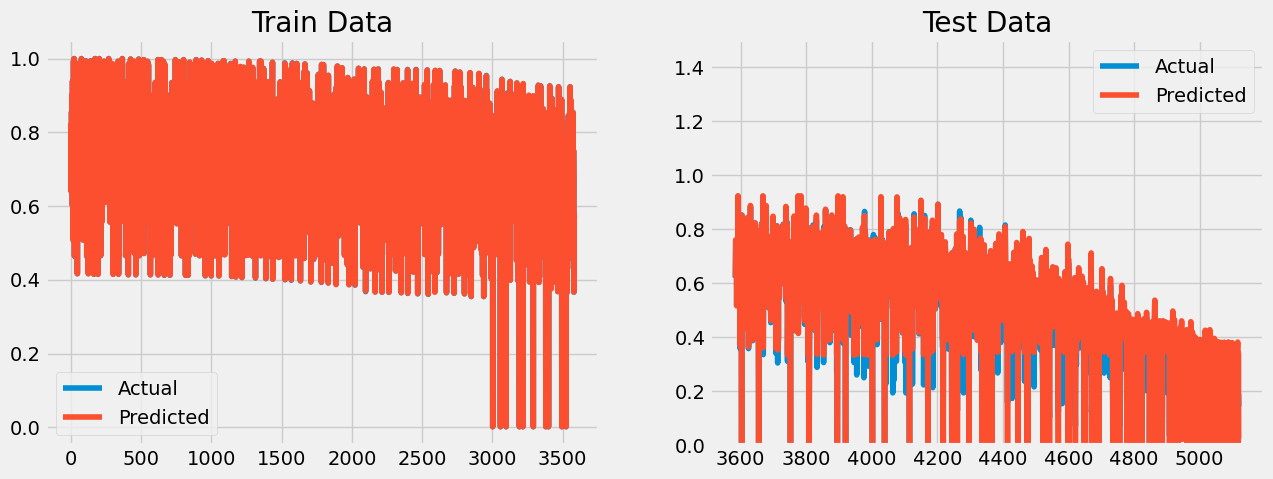

In [68]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_preds, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_preds, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()
ax[1].set_ylim(0, 1.5)  # Set the y-axis to range from 0 to 1

# Show the plots
plt.show()

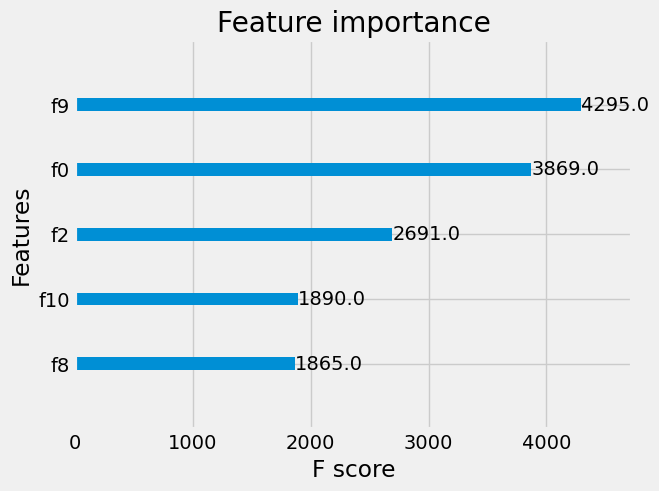

In [69]:
# Plot feature importances
plot_importance(best_model_bfs, max_num_features=5)
plt.show()


#### BEST UNGROUPED SCALED MODEL

[12:22:11] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<Figure size 1000x600 with 0 Axes>

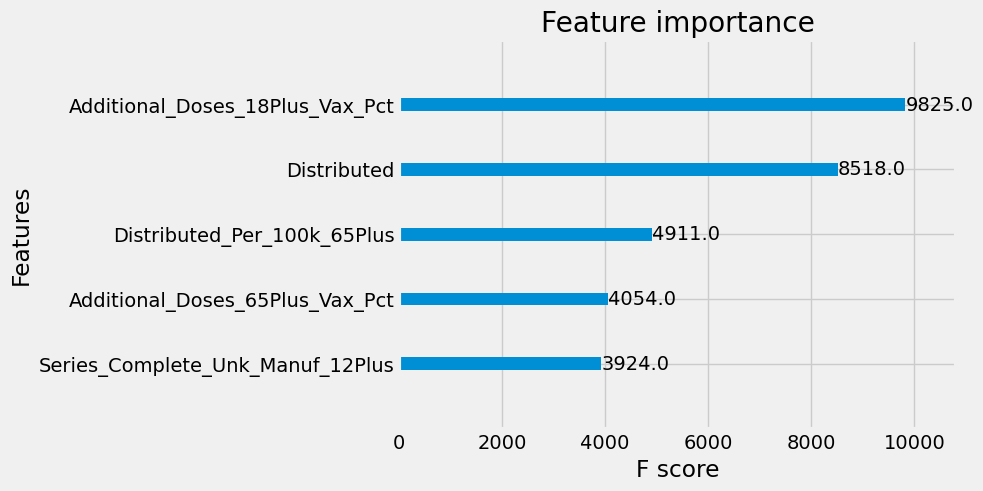

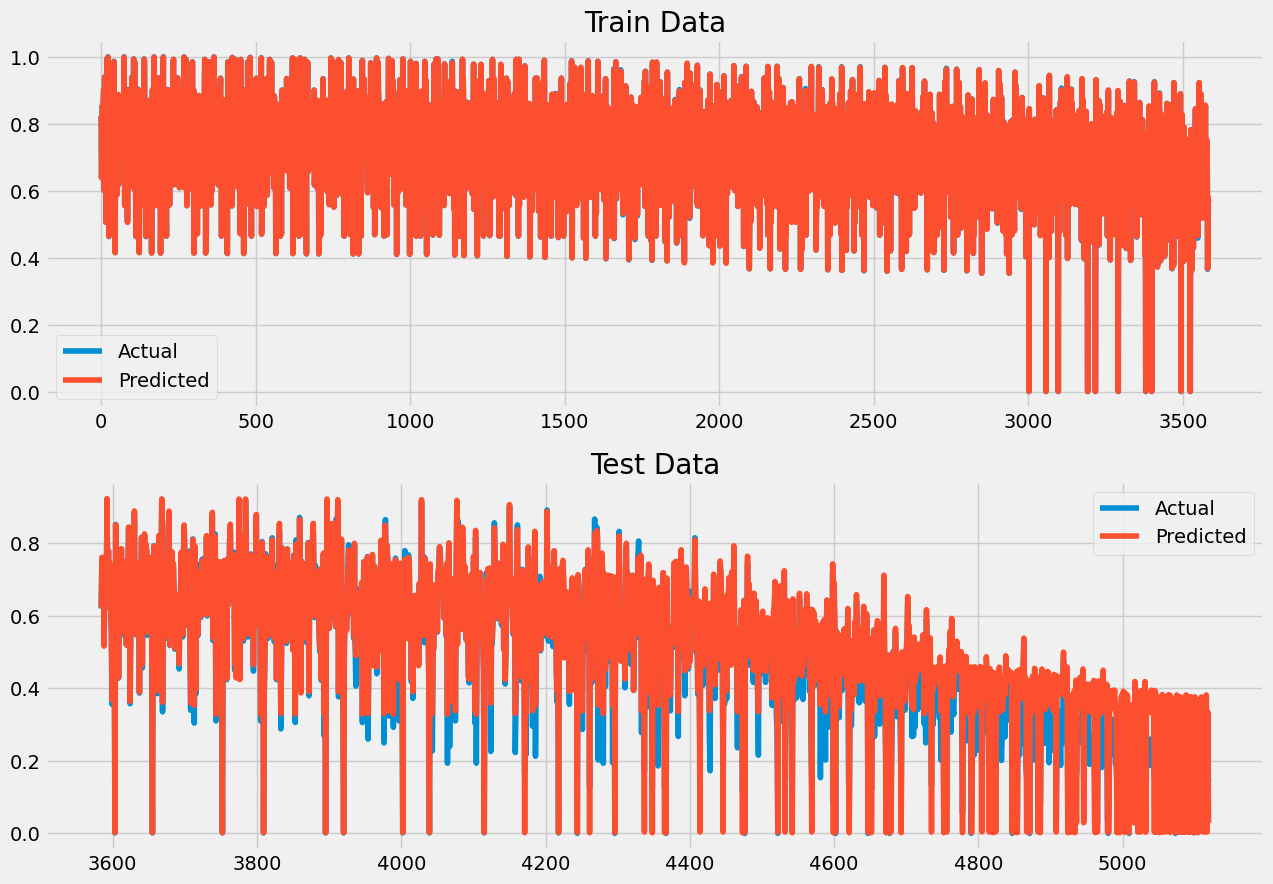

Train RMSE: 0.001250234483955796
Test RMSE: 0.06285206040645482


In [71]:

# Model parameters
params = {
    'objective': 'reg:squarederror',
    'base_score': 0.5,
    'booster': 'gbtree',
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'max_depth': 6,
    'min_child_weight': 1,
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'subsample': 1,
    'early_stopping_rounds': 10
}

# Initialize and fit the model
model = XGBRegressor(**params)
model.fit(X_train_selected_base, y_train, eval_set=[(X_train_selected_base, y_train), (X_test_selected_base, y_test)], verbose=False)

# Predictions
train_pred = model.predict(X_train_selected_base)
test_pred = model.predict(X_test_selected_base)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

# Plot feature importances
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=5)
plt.show()

# Plotting the comparison of actual vs predicted values for train and test sets
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_pred, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_pred, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()

# Show the plots
plt.show()

# Printing RMSEs
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

## Tuning ungrouped, scaled model

In [28]:
# Define hyperparameter search space
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400, 500, 1000],
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV and fit
random_search = RandomizedSearchCV(
    reg, param_distributions=param_dist, n_iter=50,
    scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=True, random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Ind

RandomizedSearchCV(cv=TimeSeriesSplit(gap=12, max_train_size=None, n_splits=3, test_size=12),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_...
                                        'n_estimators': [25, 50, 100, 150, 200,
                                                         250, 300, 400, 500,
                                                         1000],
                                        'reg_alpha': array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01]),
                                        'reg_lambda': array([1.00000000e-05, 3.16227766e-04, 1.00000000e-02, 3.16227766e-01,
       1.00000000e+01]),
                                        'subsample': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=True)

In [29]:
# Print best parameters

print(f"Best parameters found: {random_search.best_params_}")
print(f"Lowest RMSE found: {np.sqrt(np.abs(random_search.best_score_))}")

Best parameters found: {'subsample': 0.5, 'reg_lambda': 1e-05, 'reg_alpha': 0.00031622776601683794, 'n_estimators': 500, 'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.0, 'colsample_bytree': 0.625}
Lowest RMSE found: 0.006451184265931155


In [30]:
# Evaluate with cross-validation (xgb.cv)
dtrain = xgb.DMatrix(X_train, label=y_train)

cv_results = xgb.cv(
    random_search.best_params_,
    dtrain,
    num_boost_round=1000,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)

print(f"Final cross-validated RMSE: {cv_results['test-rmse-mean'].tail(1).values[0]}")


[14:18:15] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:18:15] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:18:15] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

In [31]:
# Get the best estimator from the search
best_model = random_search.best_estimator_

# Predict on the training data
train_preds = best_model.predict(X_train)

# Predict on the testing data
test_preds = best_model.predict(X_test)

# Calculate the RMSE for the train and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_preds))
test_rmse = sqrt(mean_squared_error(y_test, test_preds))

# Print RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 0.0018332915577443233
Test RMSE: 0.06762112822431253


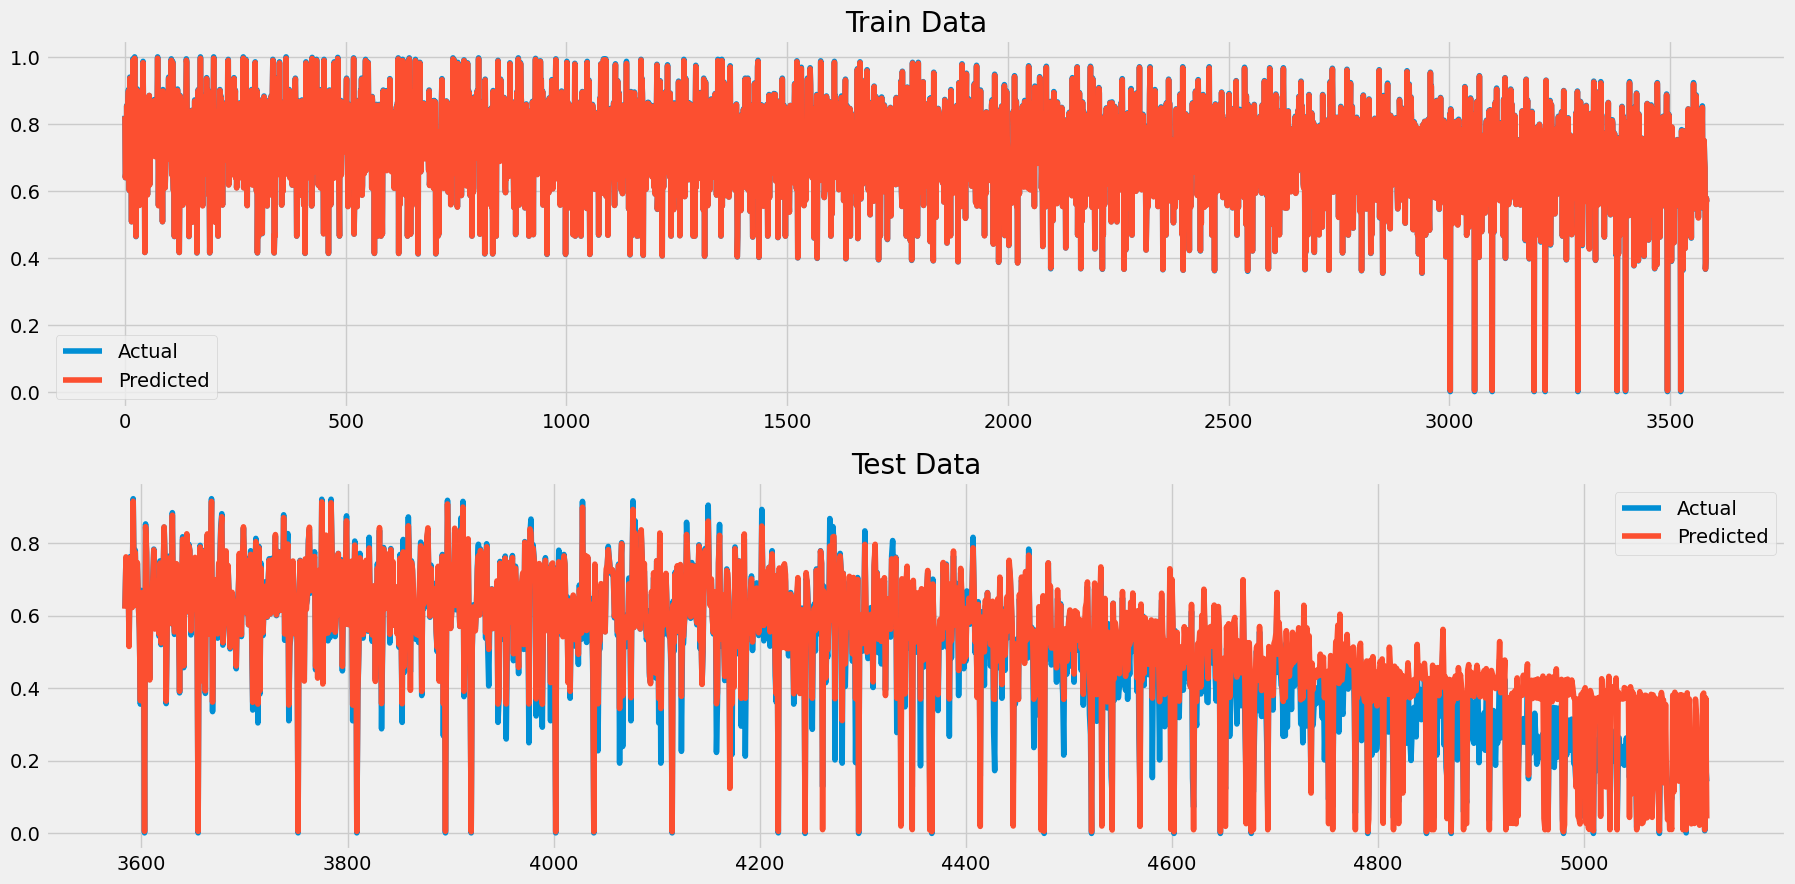

Train RMSE: 0.0018332915577443233
Test RMSE: 0.06762112822431253


In [50]:
# Best parameters
params = {
    'subsample': 0.5,
    'reg_lambda': 1e-05,
    'reg_alpha': 0.00031622776601683794,
    'min_child_weight': 2,
    'max_depth': 9,
    'learning_rate': 0.01,
    'gamma': 0.0,
    'colsample_bytree': 0.625,
    'n_estimators': 500
}

# Initialize XGBoost regressor
reg = xgb.XGBRegressor(**params)

# Fit the model
reg.fit(X_train, y_train)

# Make predictions
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Calculate RMSE for train and test sets
train_rmse = sqrt(mean_squared_error(y_train, train_pred))
test_rmse = sqrt(mean_squared_error(y_test, test_pred))

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Train plot
ax[0].plot(train.index, y_train, label='Actual')
ax[0].plot(train.index, train_pred, label='Predicted')
ax[0].set_title('Train Data')
ax[0].legend()

# Test plot
ax[1].plot(test.index, y_test, label='Actual')
ax[1].plot(test.index, test_pred, label='Predicted')
ax[1].set_title('Test Data')
ax[1].legend()

# Show the plots
plt.show()

# Print RMSE values
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


### Feature importances from tuned model

In [51]:
# 1. Extract feature importances
importances = reg.feature_importances_

# 2. Determine a threshold
threshold = np.mean(importances)

# 3. Select features based on threshold
selection = SelectFromModel(reg, threshold=threshold, prefit=True)
X_train_selected = selection.transform(X_train)
X_test_selected = selection.transform(X_test)

# 4. Retrain model with selected features
selected_model = xgb.XGBRegressor(learning_rate=0.01, n_estimators=1000, early_stopping_rounds=10)
selected_model.fit(X_train_selected, y_train)

# 5. Evaluate the retrained model
train_pred_selected = selected_model.predict(X_train_selected)
test_pred_selected = selected_model.predict(X_test_selected)

# Calculate RMSE for the retrained model
train_rmse_selected = np.sqrt(mean_squared_error(y_train, train_pred_selected))
test_rmse_selected = np.sqrt(mean_squared_error(y_test, test_pred_selected))
print(f"Train RMSE with selected features: {train_rmse_selected}")
print(f"Test RMSE with selected features: {test_rmse_selected}")

# Print the number and names of selected features
selected_features = np.array(X_train.columns)[selection.get_support()]
print(f"Number of selected features: {len(selected_features)}")
print("Selected features:", selected_features)

[16:24:40] WARNING: ../src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Train RMSE with selected features: 0.0013090484723696511
Test RMSE with selected features: 0.06320378180704123
Number of selected features: 20
Selected features: ['Admin_Per_100k_5Plus' 'Admin_Per_100k_18Plus'
 'Administered_Dose1_Recip_12PlusPop_Pct'
 'Administered_Dose1_Recip_18PlusPop_Pct' 'Series_Complete_5PlusPop_Pct'
 'Series_Complete_Janssen' 'Series_Complete_Janssen_12Plus'
 'Series_Complete_Janssen_18Plus' 'Additional_Doses_18Plus_Vax_Pct'
 'Additional_Doses_50Plus_Vax_Pct' 'Additional_Doses_65Plus_Vax_Pct'
 'Additional_Doses_Moderna' 'Additional_Doses_Janssen' 'Location_DC'
 'Location_GU' 'Location_IH2' 'Locati

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define the hyperparameter space
param_dist = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [25, 50, 100, 150, 200, 250, 300, 400, 500, 1000],
    'max_depth': np.arange(3, 10, 1),
    'min_child_weight': np.arange(1, 6, 1),
    'gamma': np.linspace(0, 0.5, 5),
    'subsample': np.linspace(0.5, 1, 5),
    'colsample_bytree': np.linspace(0.5, 1, 5),
    'reg_alpha': np.logspace(-5, 1, 5),
    'reg_lambda': np.logspace(-5, 1, 5)
}

# Initialize XGBoost regressor
xgb_reg = xgb.XGBRegressor(n_estimators=1000)

# Initialize RandomizedSearchCV
random_search_b = RandomizedSearchCV(
    estimator=xgb_reg, 
    param_distributions=param_dist, 
    n_iter=100, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Perform the tuning
random_search_b.fit(X_train_selected, y_train)

# Evaluate the best model
best_model_fs_b = random_search_b.best_estimator_
train_pred = best_model_fs_b.predict(X_train_selected)
test_pred = best_model_fs_b.predict(X_test_selected)

# Calculate RMSE for the best model
train_rmse = sqrt(mean_squared_error(y_train, train_pred))
test_rmse = sqrt(mean_squared_error(y_test, test_pred))

# Print the best parameters and RMSE values
print("Best parameters:", random_search_b.best_params_)
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/avaserin/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a futur

Best parameters: {'subsample': 0.75, 'reg_lambda': 0.01, 'reg_alpha': 1e-05, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.0, 'colsample_bytree': 0.875}
Train RMSE: 0.0005745397001864632
Test RMSE: 0.06604594797866337
